In [1]:
import torch
from torch import optim, nn
import numpy as np

import json
from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image, load_contour
from UNet import UNet
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from IPython.display import clear_output

from UNet import ssim_loss
from models.vqvae import VQVAE

device = "cuda"

pimages = load_dataset().to(device)
pimages.shape

torch.Size([5, 386, 3, 64, 64])

torch.Size([4, 3, 72, 72])


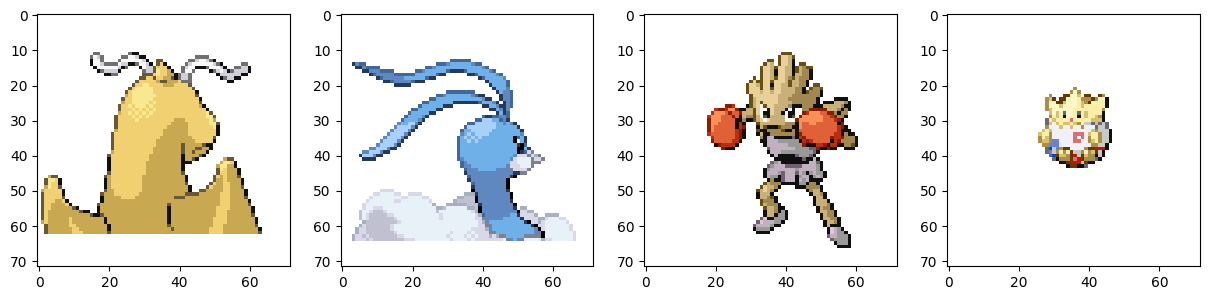

In [2]:
class Sobel():
    def __init__(self):
        self.weight = [[1, 0, -1], [0, 0, 0], [1, 0, -1]]
        self.weight = torch.tensor(self.weight, dtype=torch.float32)
        self.weight = self.weight[None, None, :, :].expand(3, -1, -1, -1)

    def __call__(self, sample):
        return nn.functional.conv2d(sample, self.weight.to(sample.device), groups=3)
sobel = Sobel()

pos_transform = v2.Compose([
    v2.Pad(6, 1.0),
    v2.RandomCrop((64 + 6, 64 + 6)),
    v2.Pad(1, 1.0),
    #v2.RandomApply([v2.RandomAffine(0, (0, 0), (0.8, 1.4), 0, fill=1.0)], .2),
    #v2.RandomApply([v2.RandomRotation(360, fill=1.0)], .2),
    #Sobel(),
])
#col_transform = v2.Compose([
#    v2.RandomApply([v2.ColorJitter()], .3),
#    v2.RandomApply([v2.RandomChannelPermutation()], .3),
#    v2.RandomGrayscale(p = .3),
#])

bs = 4
source = torch.randint(0, 5, (bs,))
batch = torch.randperm(385)[:bs]
x0 = pimages[source, batch]
#x0 = torch.stack([col_transform(pos_transform(x)) for x in x0], dim=0)
x0 = torch.stack([pos_transform(x) for x in x0], dim=0)
print(x0.shape)

fig, axes = plt.subplots(1, 4, figsize=(15, 15))
plot_image(x0[0], axes[0])
plot_image(x0[1], axes[1])
plot_image(x0[2], axes[2])
plot_image(x0[3], axes[3])
plt.show()

In [3]:
#https://www.researchgate.net/figure/The-Vision-Transformer-architecture-a-the-main-architecture-of-the-model-b-the_fig2_348947034
class Transformer(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.mha = nn.MultiheadAttention(emb_dim, num_heads=2, batch_first=True) ##2?

        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 4 * emb_dim),
            nn.GELU(),
            nn.Linear(4 * emb_dim, emb_dim),
            #nn.Dropout(0.1),
        )

    def forward(self, x):
        x_ln = self.ln1(x)
        att, _ = self.mha(x_ln, x_ln, x_ln)
        
        att = self.ln2(att + x)
        return self.mlp(att) + att

In [4]:
#https://medium.com/@14prakash/masked-autoencoders-9e0f7a4a2585
class MyMAE(nn.Module):
    def __init__(self, img_size, patch_size, emb_dim):
        super().__init__()
        assert img_size % patch_size == 0

        self.emb_dim = emb_dim
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (self.img_size // self.patch_size) ** 2
        self.masked_size = int(0.75 * self.num_patches)

        self.patch_embedding = nn.Conv2d(3, self.emb_dim, 
                                         kernel_size=patch_size, 
                                         stride=patch_size,
                                         bias=False) #pos embedding?

        self.pos_embedding = nn.Parameter(torch.zeros(self.num_patches, self.emb_dim), requires_grad=False)
        
        self.encoder = nn.Sequential(*[Transformer(self.emb_dim) for i in range(16)])
        self.decoder = nn.Sequential(*[Transformer(self.emb_dim) for i in range(2)])

        self.decoder_emb_dim = self.emb_dim
        self.decoder_emb = nn.Linear(self.emb_dim, self.decoder_emb_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.decoder_emb_dim))
        torch.nn.init.normal_(self.mask_token, std=.02)

        self.decoder_pos_emb = nn.Parameter(torch.zeros(self.num_patches, self.decoder_emb_dim))

        self.img_recov = nn.Linear(self.decoder_emb_dim, 3 * (self.patch_size ** 2))
        

    def forward(self, x):
        bs, _, _, _ = x.shape
        device = x.device

        patches = self.patch_embedding(x)
        patches = patches.flatten(2, 3).transpose(1, 2)

        mask = torch.randperm(self.num_patches, device=device) #img size independent?
        mask = mask[:-self.masked_size]
        masked = patches[:, mask, :]

        pos_emb = self.pos_embedding[mask, :]
        tokens = masked + pos_emb[None, ...]        
        features = self.encoder(tokens)

        ###### bottleneck

        tokens = self.mask_token.repeat(bs, self.num_patches, 1)
        tokens[:, mask, :] = self.decoder_emb(features)

        tokens = tokens + self.decoder_pos_emb
        features = self.decoder(tokens)

        image = self.img_recov(features)

        image = image.transpose(1,2)
        image = nn.functional.fold(image, 
                                   kernel_size=self.patch_size, 
                                   output_size=self.img_size, 
                                   stride=self.patch_size)
        
        return image

  0%|                                                                                                                                     | 0/250000 [00:00<?, ?it/s]

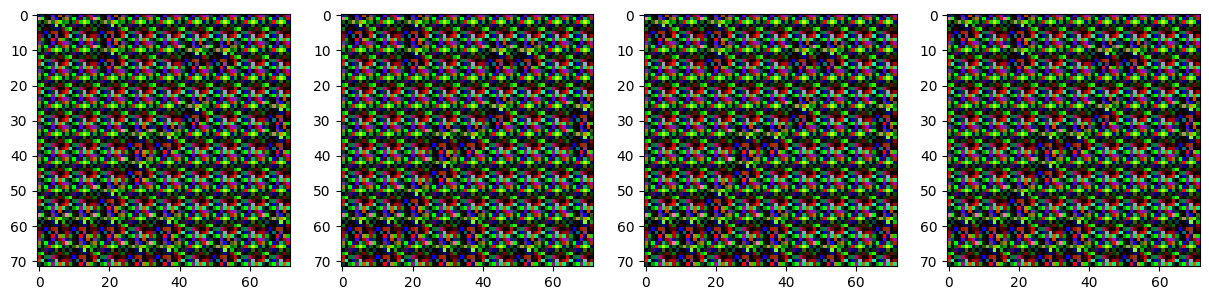

  1%|▉                                                                                                                       | 2000/250000 [00:33<1:06:32, 62.11it/s]

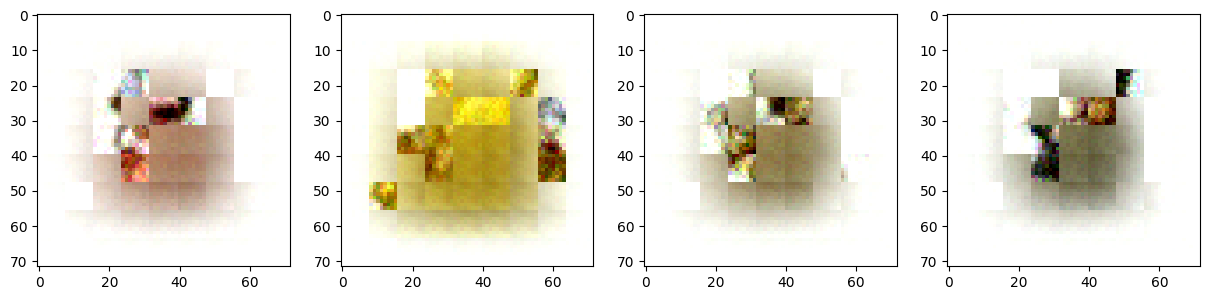

  2%|█▉                                                                                                                      | 4000/250000 [01:05<1:06:49, 61.35it/s]

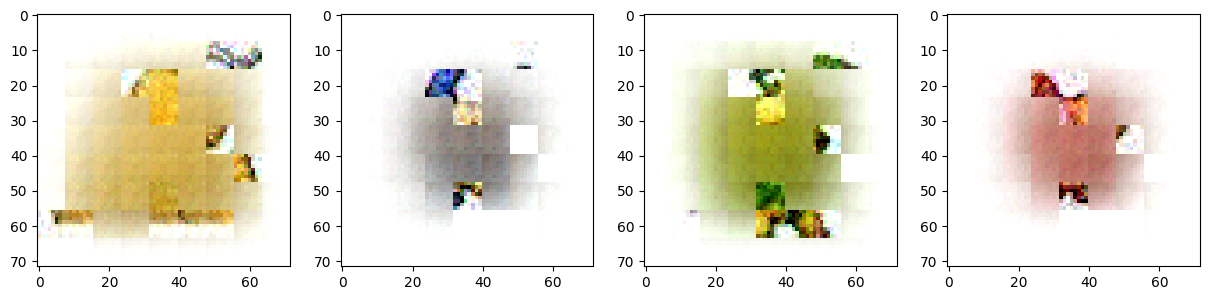

  2%|██▉                                                                                                                     | 6000/250000 [01:38<1:06:56, 60.75it/s]

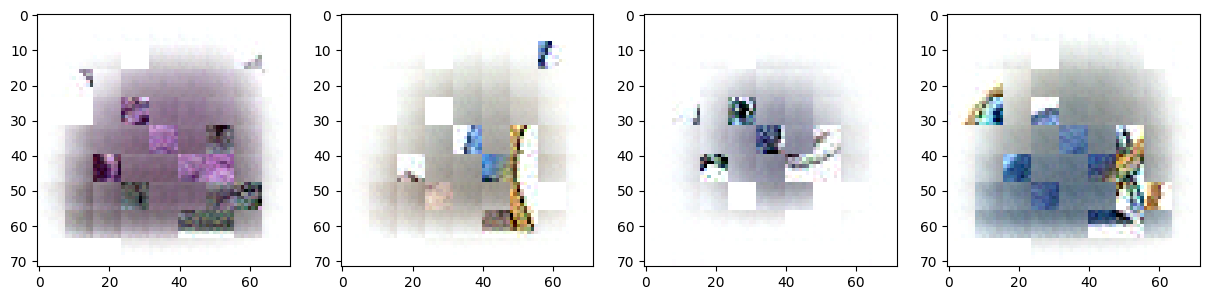

  3%|███▊                                                                                                                    | 8000/250000 [02:11<1:05:14, 61.82it/s]

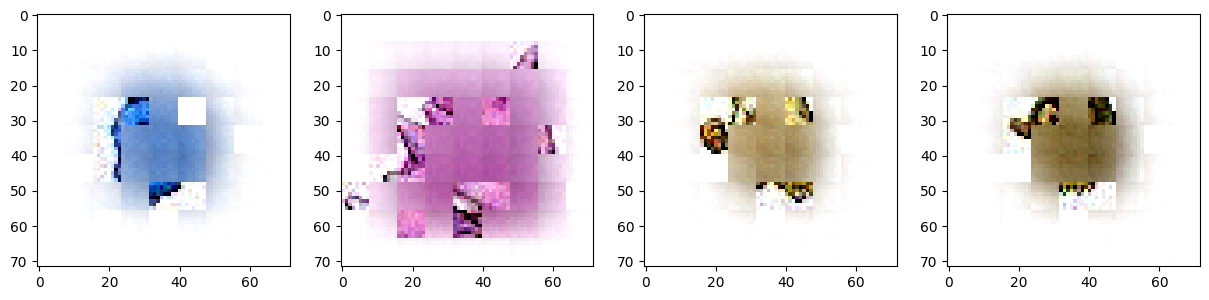

  4%|████▊                                                                                                                  | 10000/250000 [02:44<1:04:31, 61.99it/s]

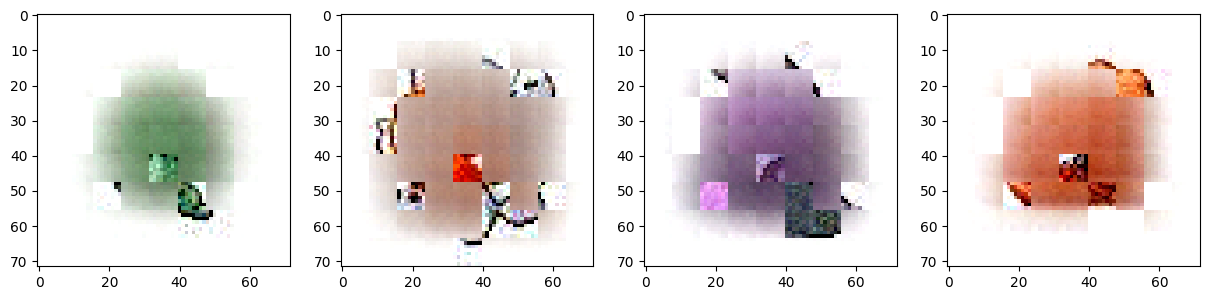

  5%|█████▋                                                                                                                 | 12000/250000 [03:17<1:04:33, 61.45it/s]

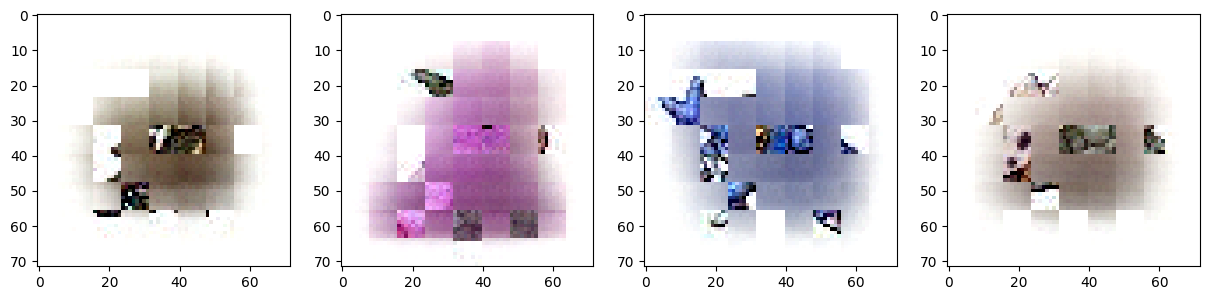

  6%|██████▋                                                                                                                | 14000/250000 [03:50<1:04:16, 61.20it/s]

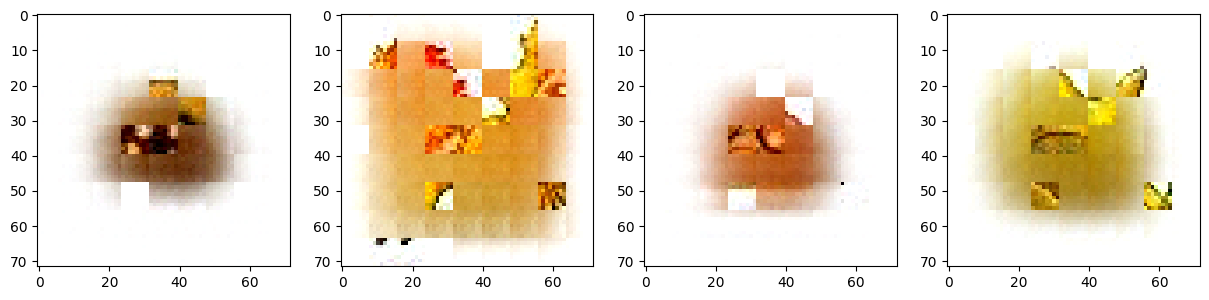

  6%|███████▌                                                                                                               | 16000/250000 [04:23<1:04:27, 60.50it/s]

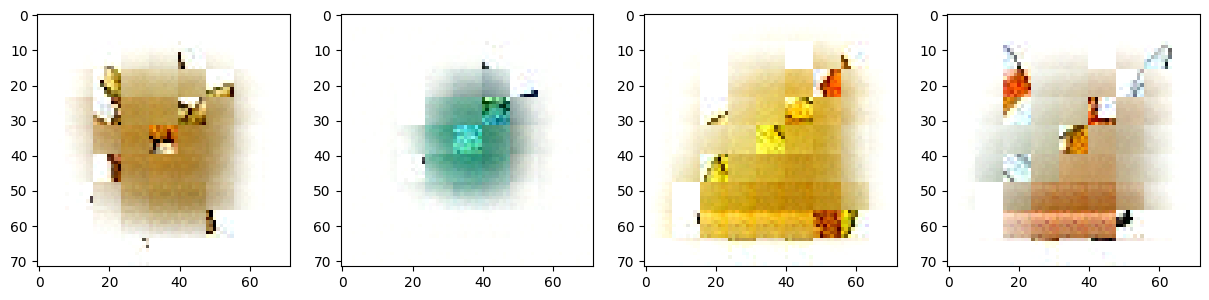

  7%|████████▌                                                                                                              | 18000/250000 [04:56<1:04:08, 60.29it/s]

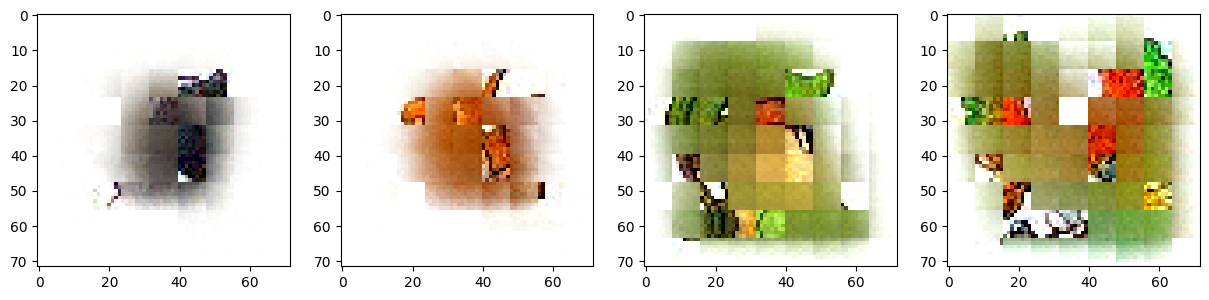

  8%|█████████▌                                                                                                             | 20000/250000 [05:29<1:04:22, 59.55it/s]

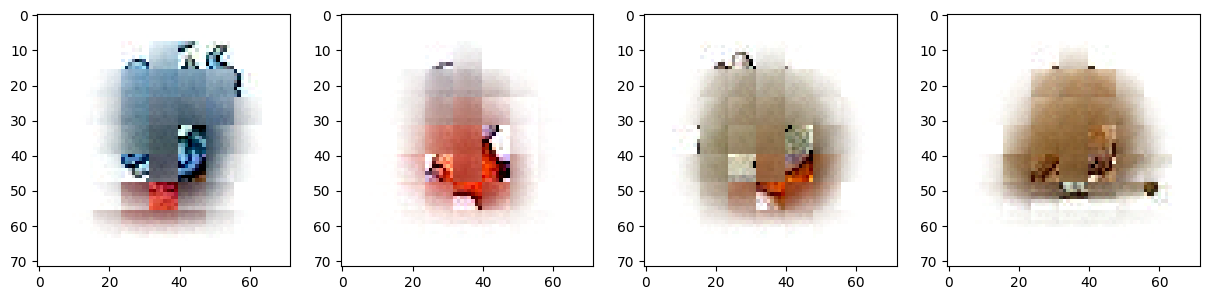

  9%|██████████▍                                                                                                            | 22000/250000 [06:02<1:03:11, 60.13it/s]

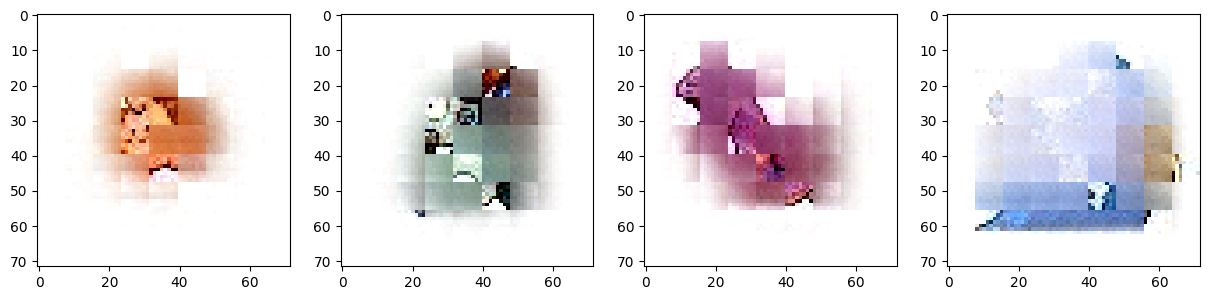

 10%|███████████▍                                                                                                           | 24000/250000 [06:35<1:01:33, 61.19it/s]

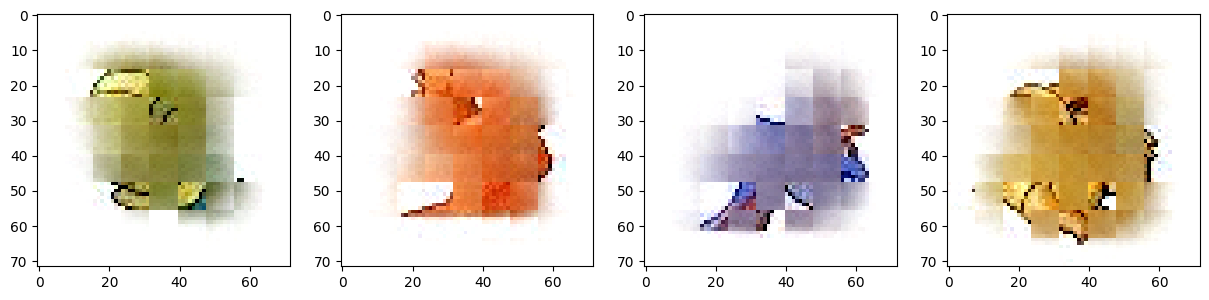

 10%|████████████▍                                                                                                          | 26000/250000 [07:08<1:02:12, 60.02it/s]

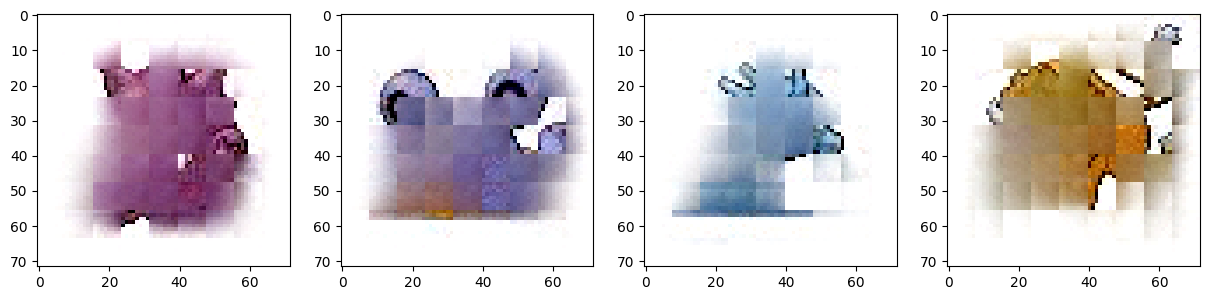

 11%|█████████████▎                                                                                                         | 28000/250000 [07:41<1:01:15, 60.41it/s]

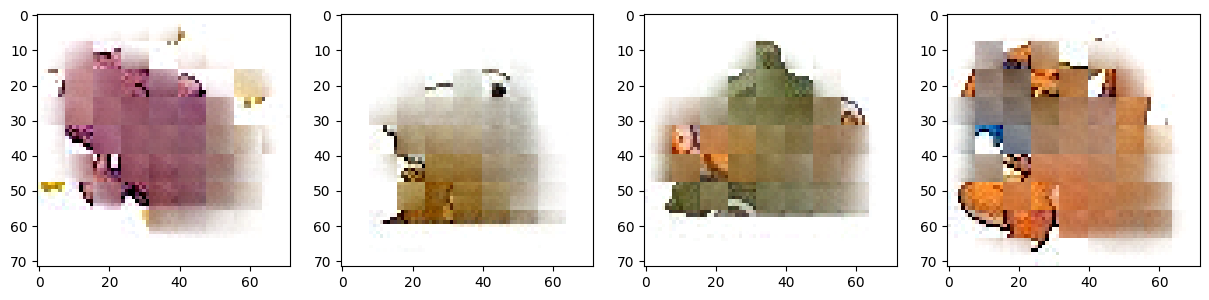

 12%|██████████████▎                                                                                                        | 30000/250000 [08:14<1:00:19, 60.79it/s]

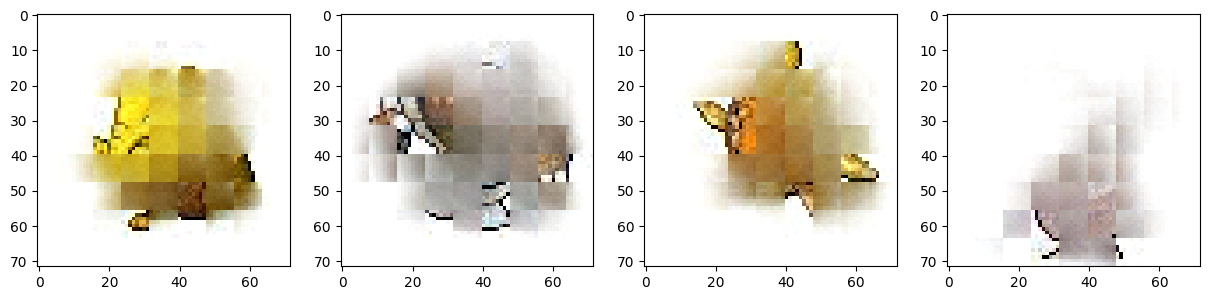

 13%|███████████████▍                                                                                                         | 32000/250000 [08:47<59:26, 61.12it/s]

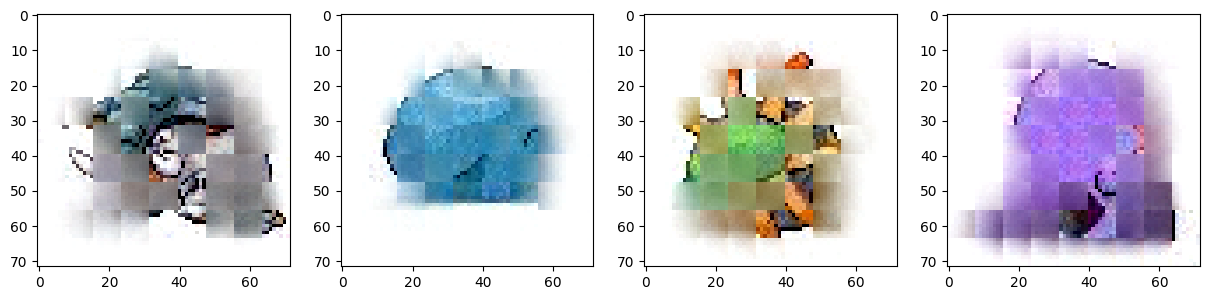

 14%|████████████████▍                                                                                                        | 34000/250000 [09:20<58:50, 61.18it/s]

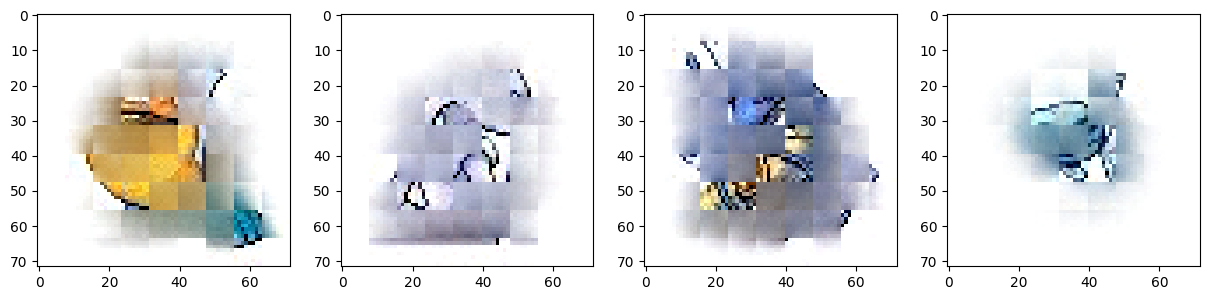

 14%|█████████████████▍                                                                                                       | 36000/250000 [09:53<59:15, 60.18it/s]

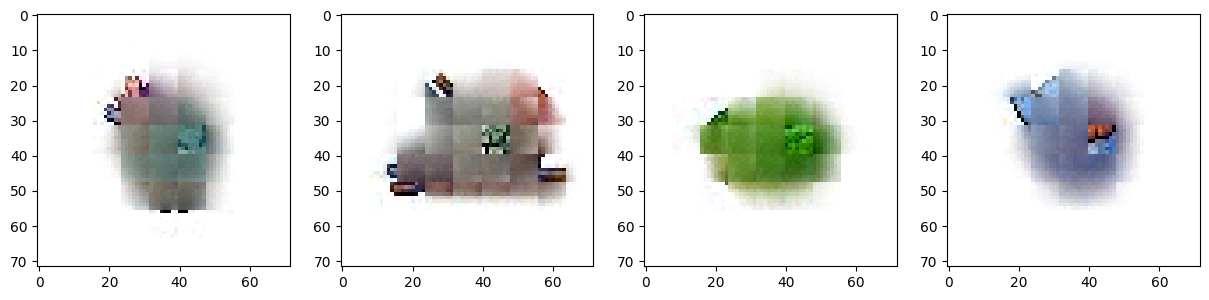

 15%|██████████████████▍                                                                                                      | 38000/250000 [10:26<57:49, 61.10it/s]

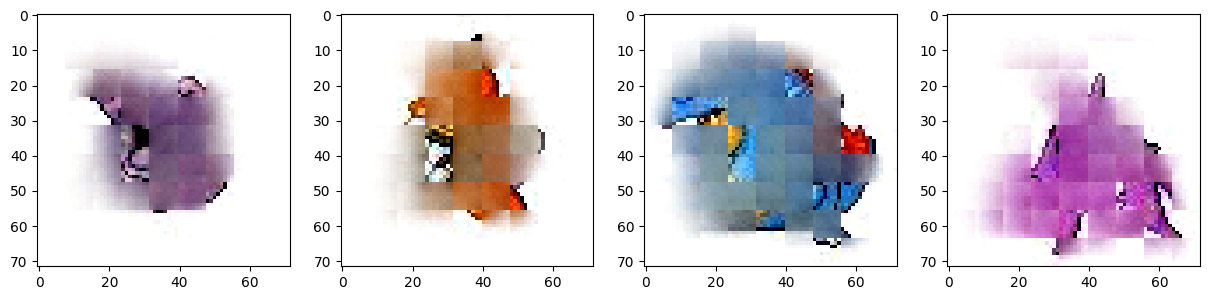

 16%|███████████████████▎                                                                                                     | 40000/250000 [10:59<56:27, 62.00it/s]

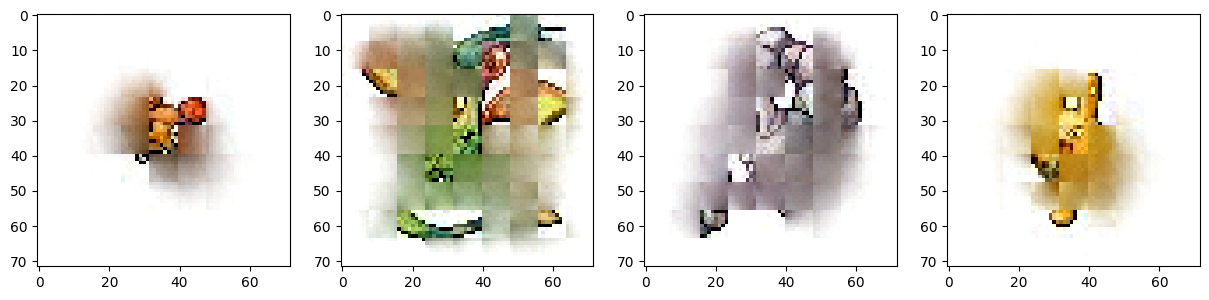

 17%|████████████████████▎                                                                                                    | 42000/250000 [11:32<56:42, 61.12it/s]

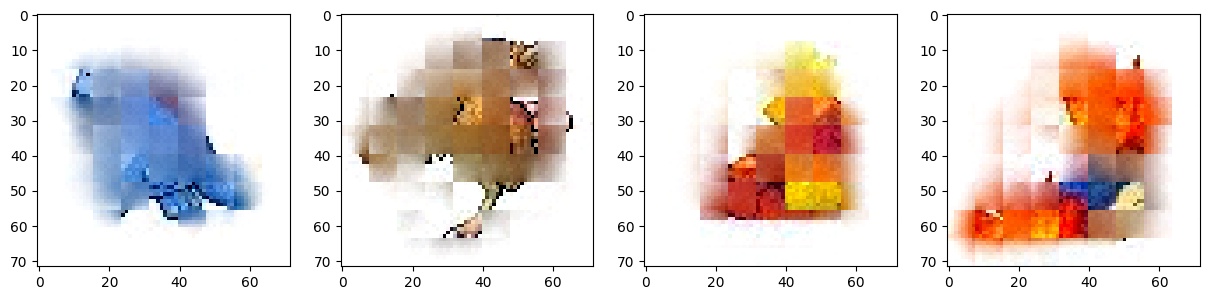

 18%|█████████████████████▎                                                                                                   | 44000/250000 [12:05<55:38, 61.71it/s]

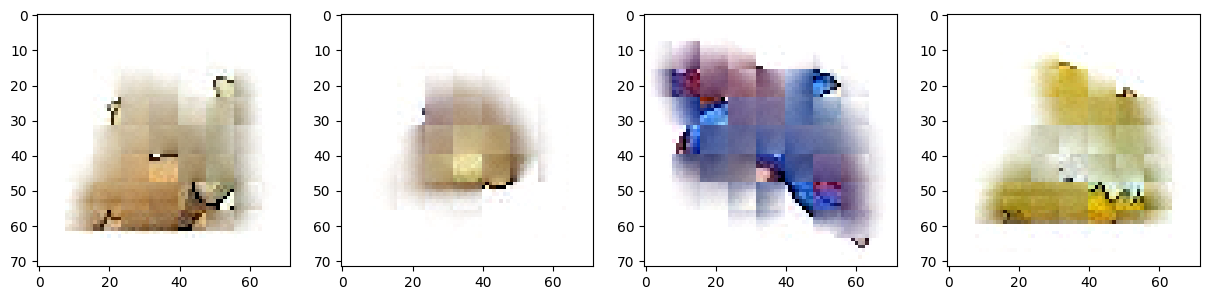

 18%|██████████████████████▎                                                                                                  | 46000/250000 [12:38<56:38, 60.03it/s]

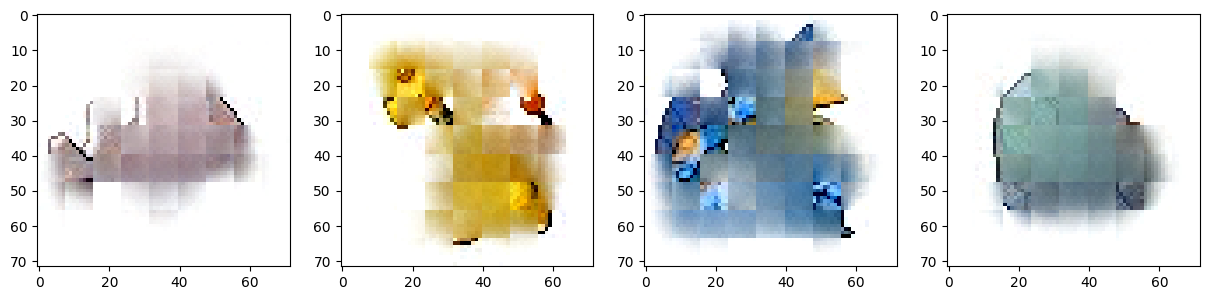

 19%|███████████████████████▏                                                                                                 | 48000/250000 [13:11<56:50, 59.22it/s]

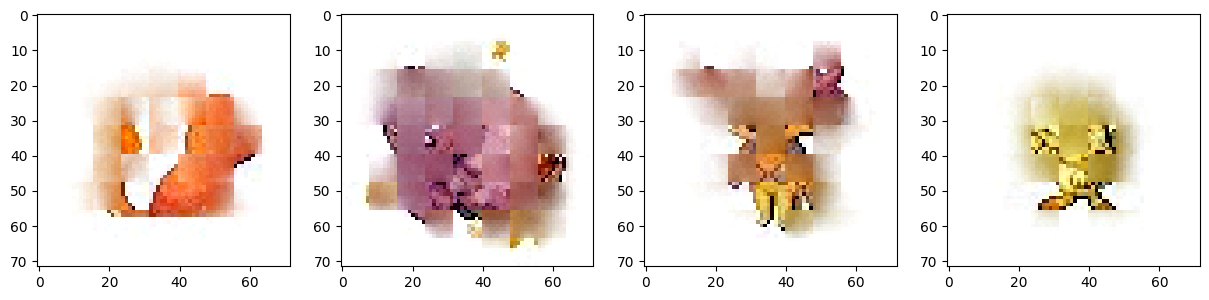

 20%|████████████████████████▏                                                                                                | 50000/250000 [13:44<55:33, 60.00it/s]

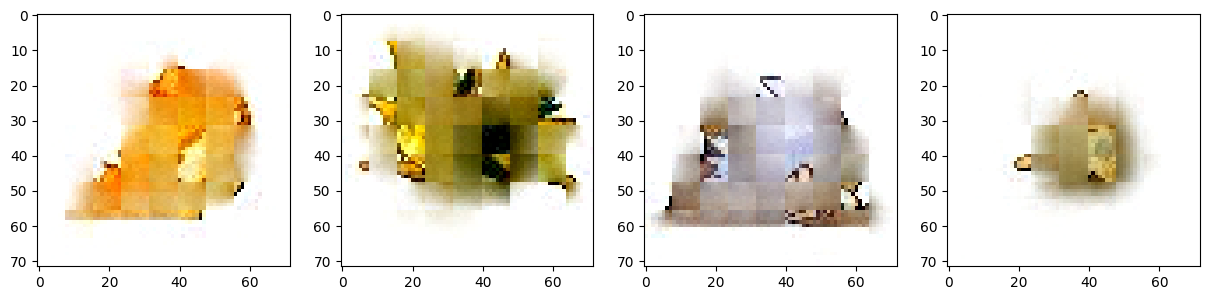

 21%|█████████████████████████▏                                                                                               | 52000/250000 [14:17<53:20, 61.86it/s]

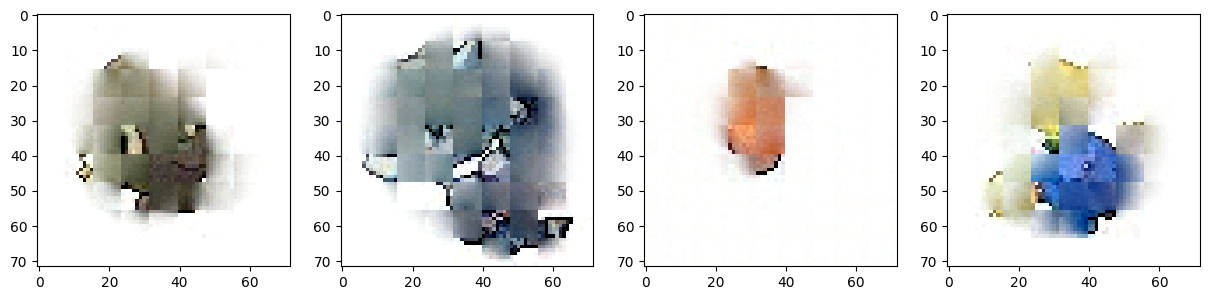

 22%|██████████████████████████▏                                                                                              | 54000/250000 [14:50<53:11, 61.41it/s]

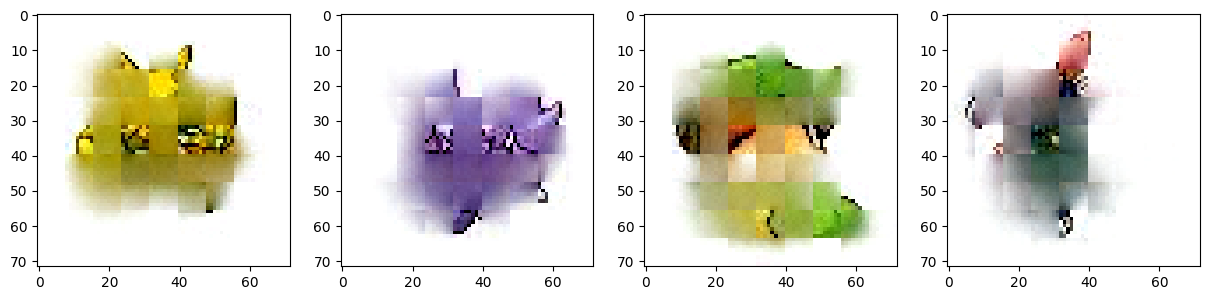

 22%|███████████████████████████                                                                                              | 56000/250000 [15:23<53:23, 60.55it/s]

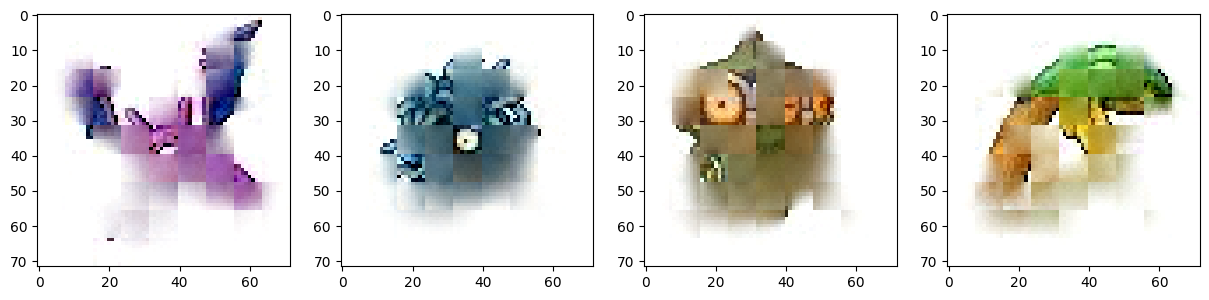

 23%|████████████████████████████                                                                                             | 58000/250000 [15:56<52:56, 60.45it/s]

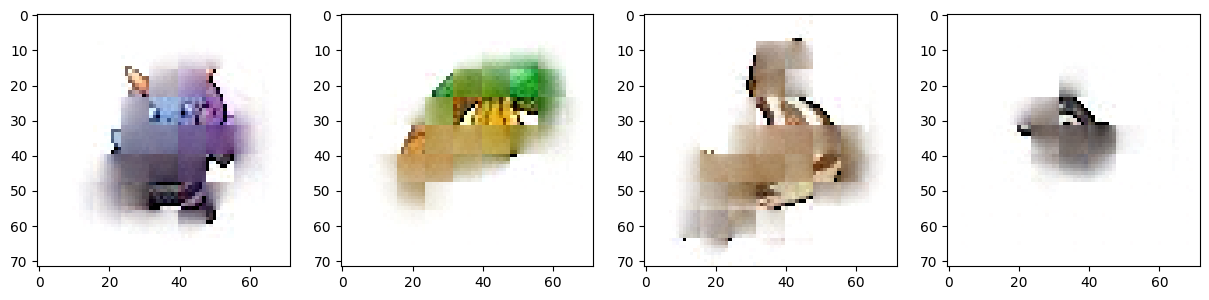

 24%|█████████████████████████████                                                                                            | 60000/250000 [16:29<52:52, 59.89it/s]

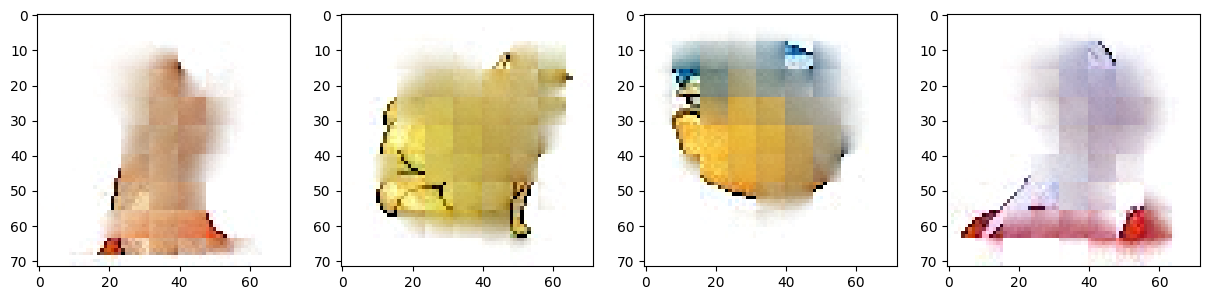

 25%|██████████████████████████████                                                                                           | 62000/250000 [17:02<51:34, 60.74it/s]

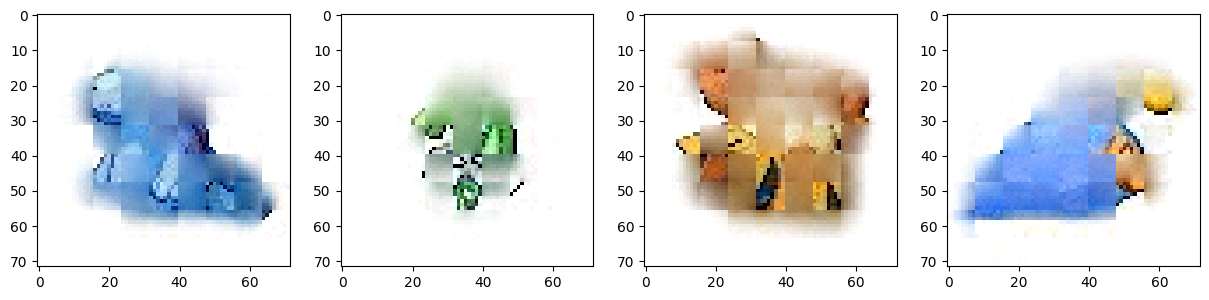

 26%|██████████████████████████████▉                                                                                          | 64000/250000 [17:36<51:32, 60.15it/s]

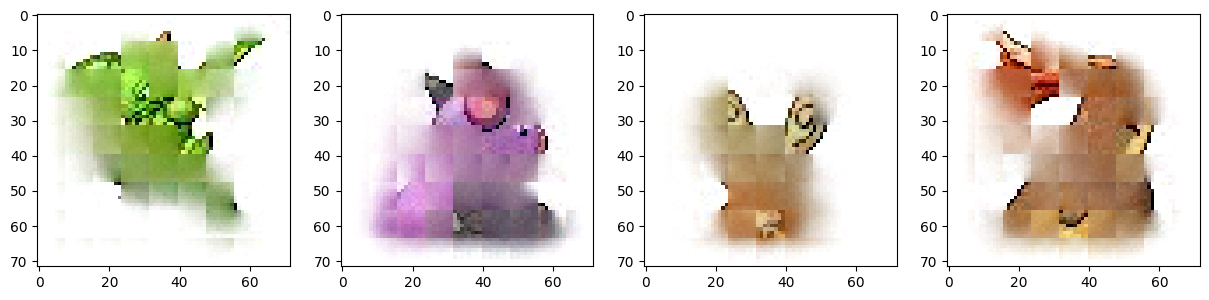

 26%|███████████████████████████████▉                                                                                         | 66000/250000 [18:08<49:48, 61.58it/s]

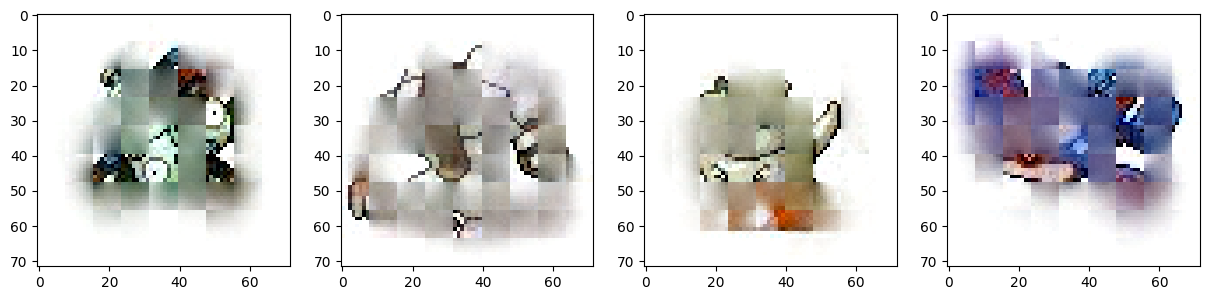

 27%|████████████████████████████████▉                                                                                        | 68000/250000 [18:41<49:49, 60.89it/s]

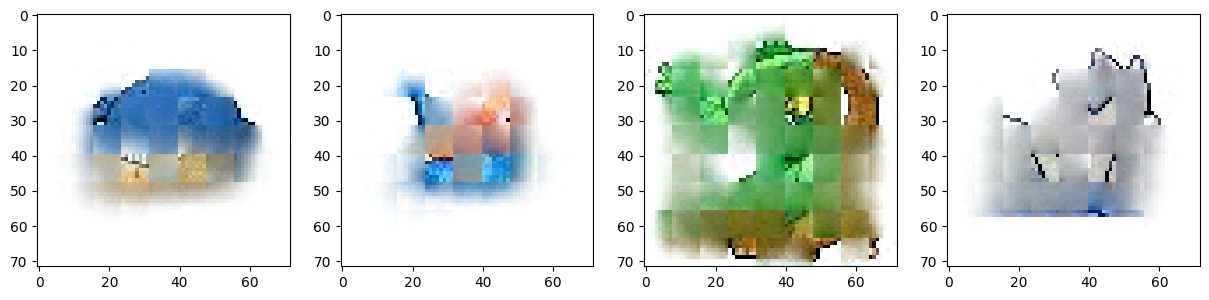

 28%|█████████████████████████████████▉                                                                                       | 70000/250000 [19:14<49:52, 60.15it/s]

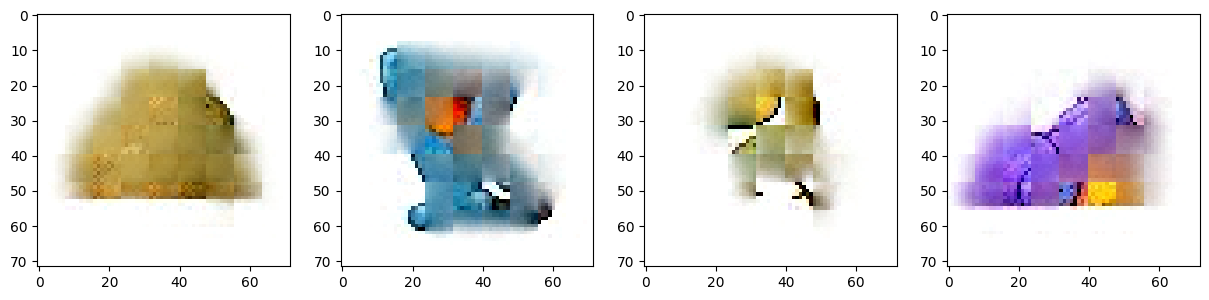

 29%|██████████████████████████████████▊                                                                                      | 72000/250000 [19:47<48:01, 61.77it/s]

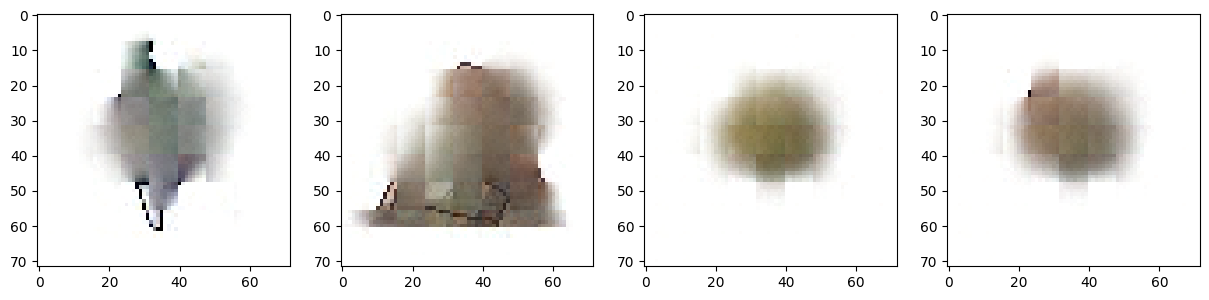

 30%|███████████████████████████████████▊                                                                                     | 74000/250000 [20:20<48:19, 60.69it/s]

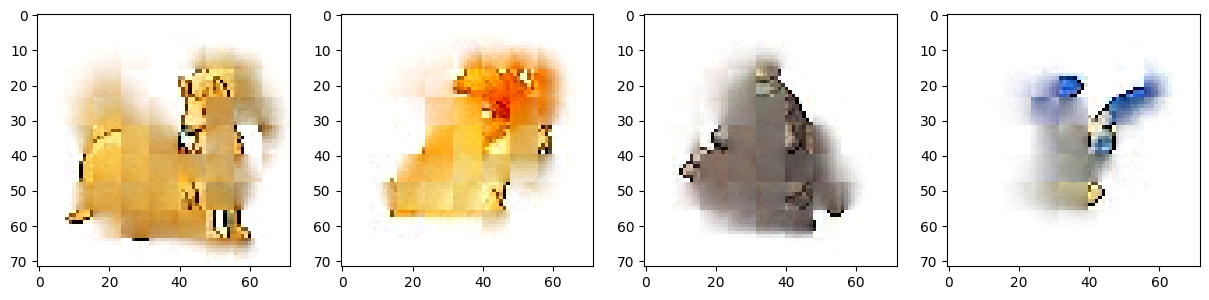

 30%|████████████████████████████████████▊                                                                                    | 76000/250000 [20:53<47:43, 60.77it/s]

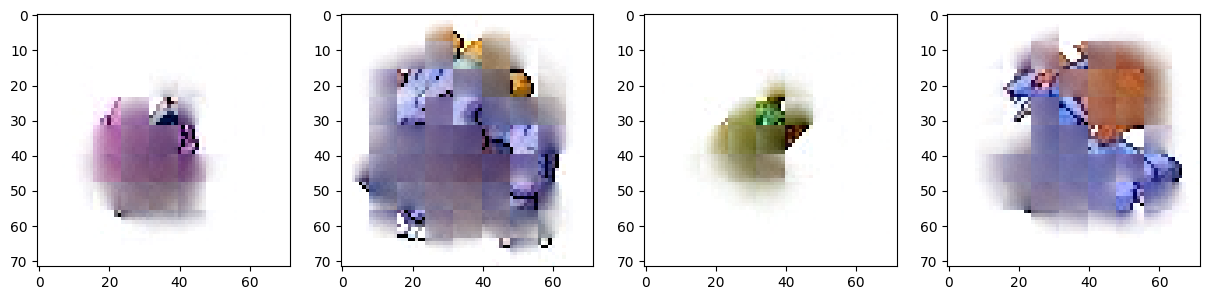

 31%|█████████████████████████████████████▊                                                                                   | 78000/250000 [21:26<46:49, 61.22it/s]

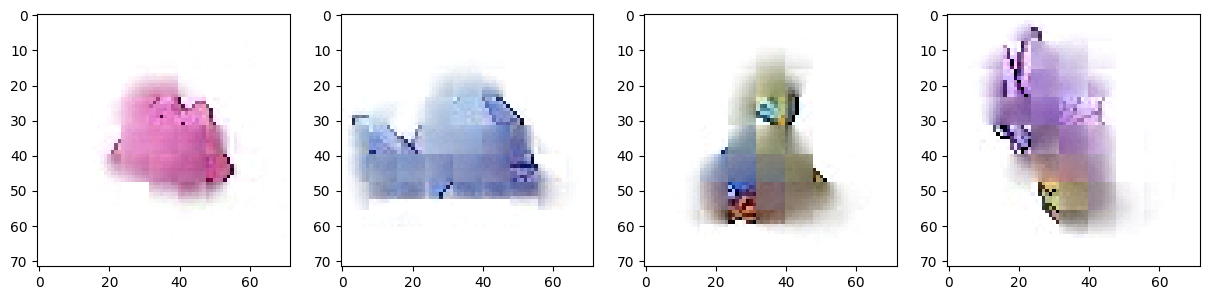

 32%|██████████████████████████████████████▋                                                                                  | 80000/250000 [21:59<45:57, 61.64it/s]

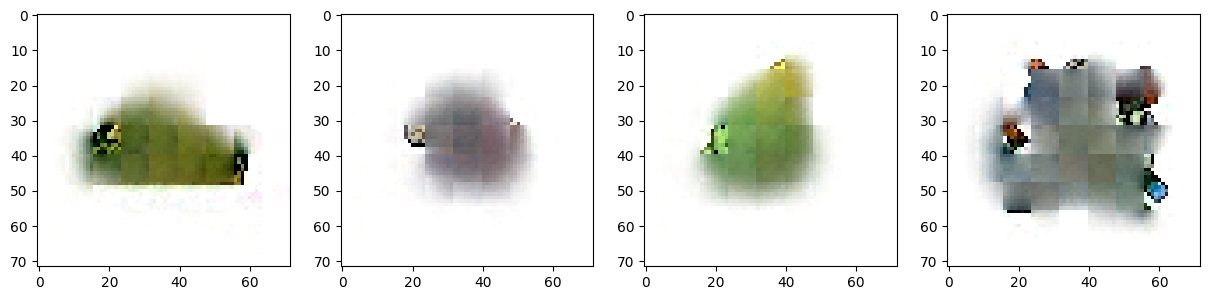

 33%|███████████████████████████████████████▋                                                                                 | 82000/250000 [22:32<45:36, 61.40it/s]

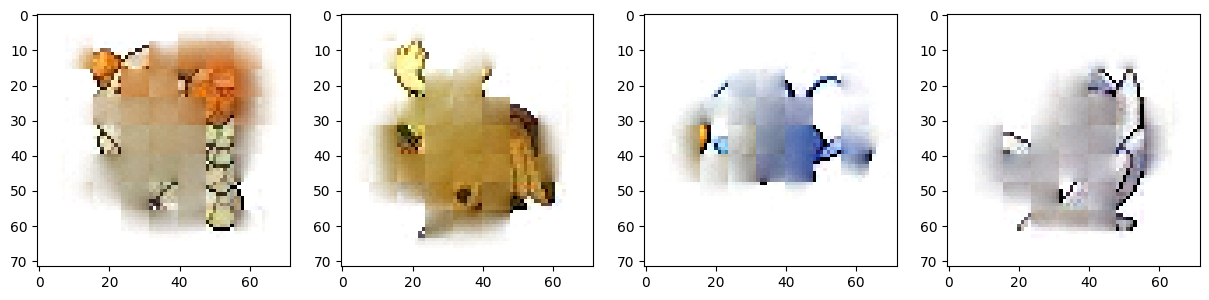

 34%|████████████████████████████████████████▋                                                                                | 84000/250000 [23:05<45:17, 61.07it/s]

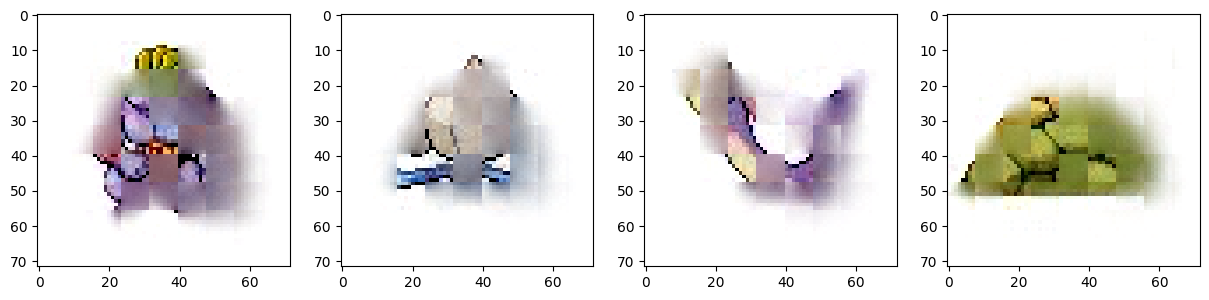

 34%|█████████████████████████████████████████▌                                                                               | 86000/250000 [23:38<45:05, 60.62it/s]

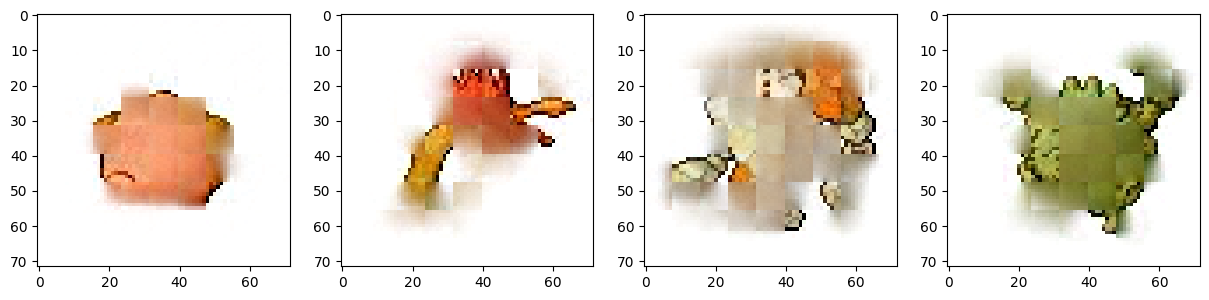

 35%|██████████████████████████████████████████▌                                                                              | 88000/250000 [24:11<43:53, 61.52it/s]

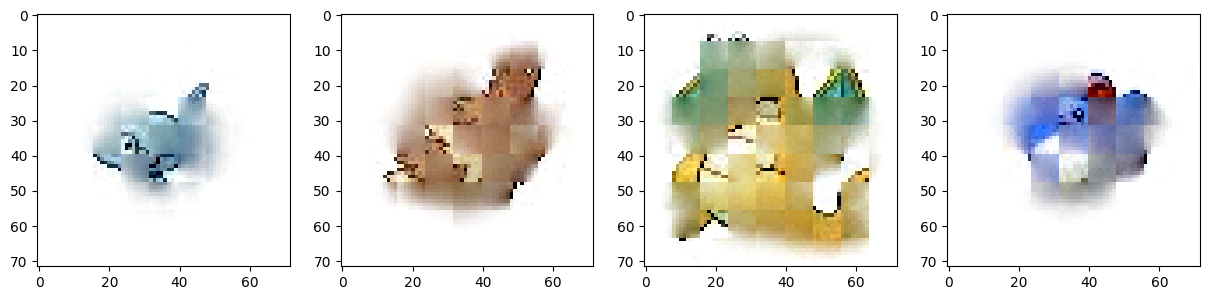

 36%|███████████████████████████████████████████▌                                                                             | 90000/250000 [24:44<43:44, 60.96it/s]

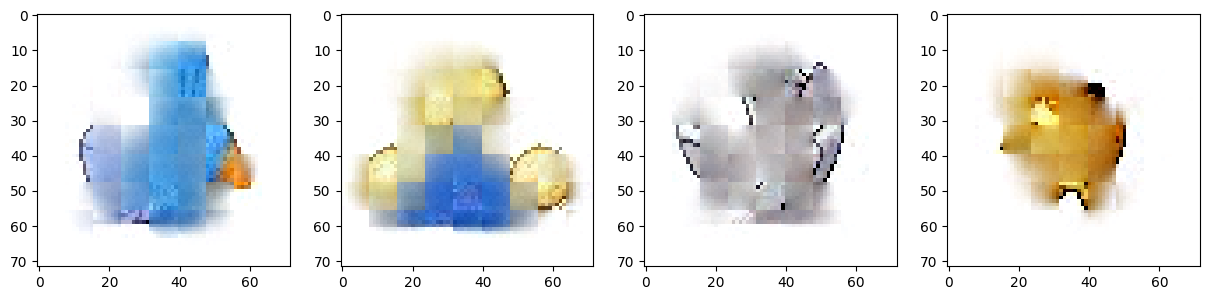

 37%|████████████████████████████████████████████▌                                                                            | 92000/250000 [25:18<43:56, 59.93it/s]

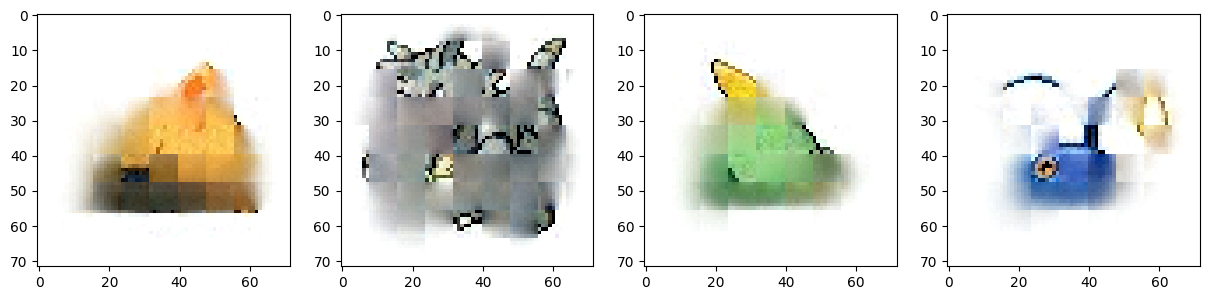

 38%|█████████████████████████████████████████████▍                                                                           | 94000/250000 [25:50<42:13, 61.58it/s]

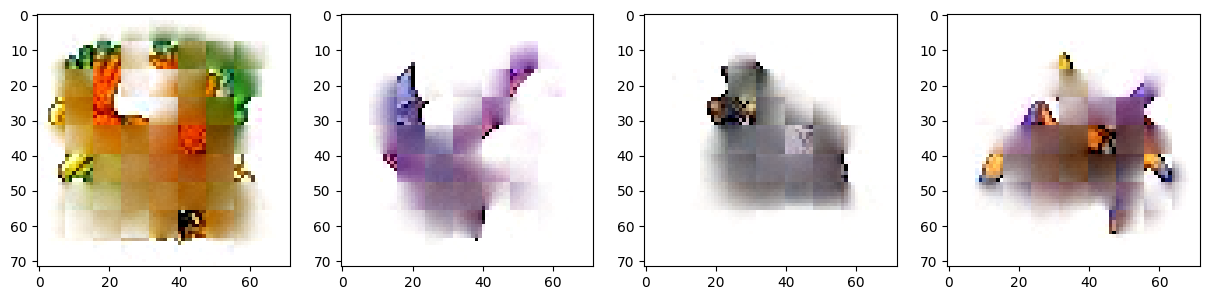

 38%|██████████████████████████████████████████████▍                                                                          | 96000/250000 [26:23<42:06, 60.97it/s]

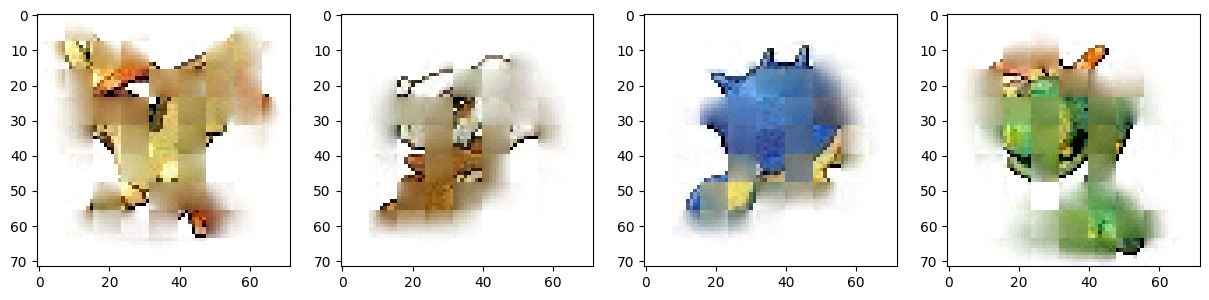

 39%|███████████████████████████████████████████████▍                                                                         | 98000/250000 [26:56<42:19, 59.86it/s]

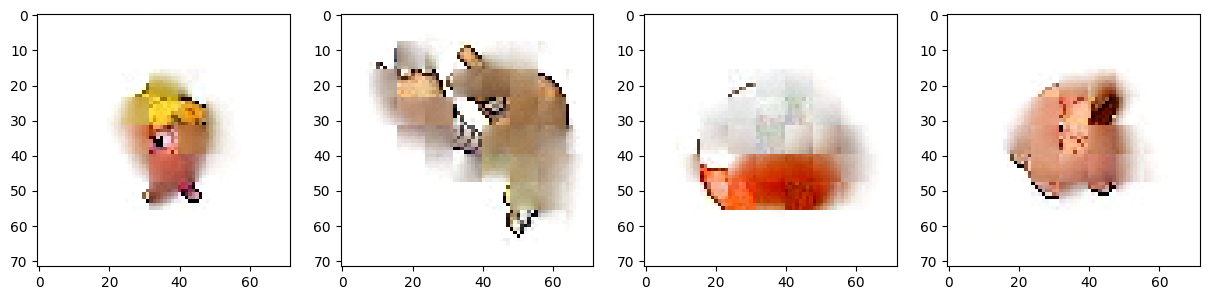

 40%|████████████████████████████████████████████████                                                                        | 100000/250000 [27:29<41:45, 59.87it/s]

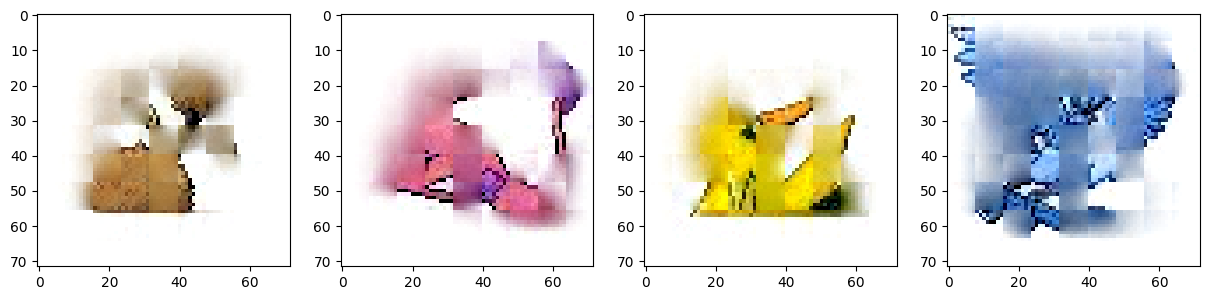

 41%|████████████████████████████████████████████████▉                                                                       | 102000/250000 [28:03<41:00, 60.14it/s]

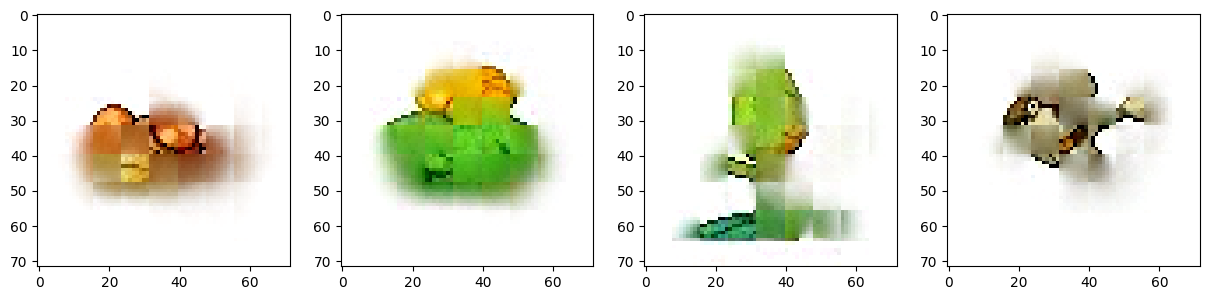

 42%|█████████████████████████████████████████████████▉                                                                      | 104000/250000 [28:36<40:07, 60.64it/s]

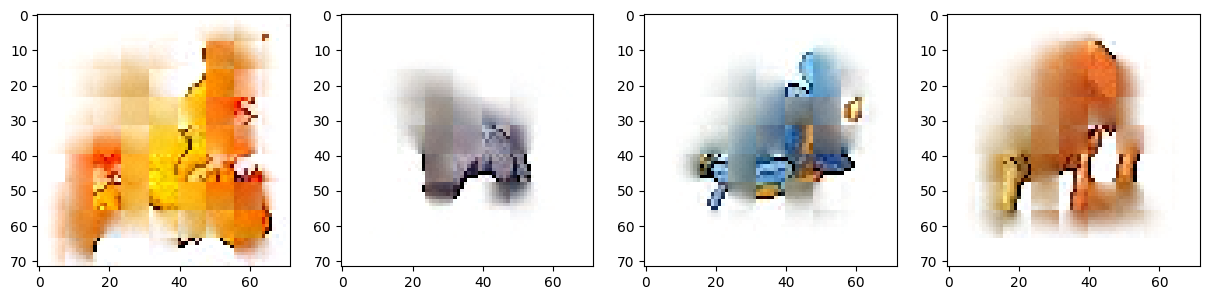

 42%|██████████████████████████████████████████████████▉                                                                     | 106000/250000 [29:09<39:34, 60.65it/s]

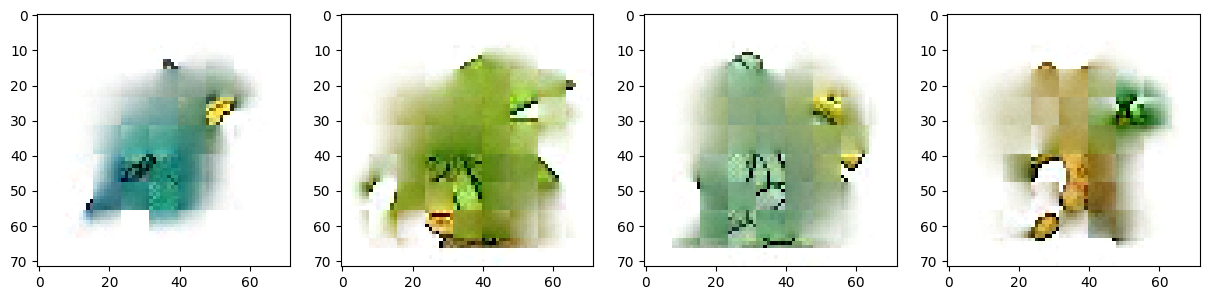

 43%|███████████████████████████████████████████████████▊                                                                    | 108000/250000 [29:42<38:43, 61.12it/s]

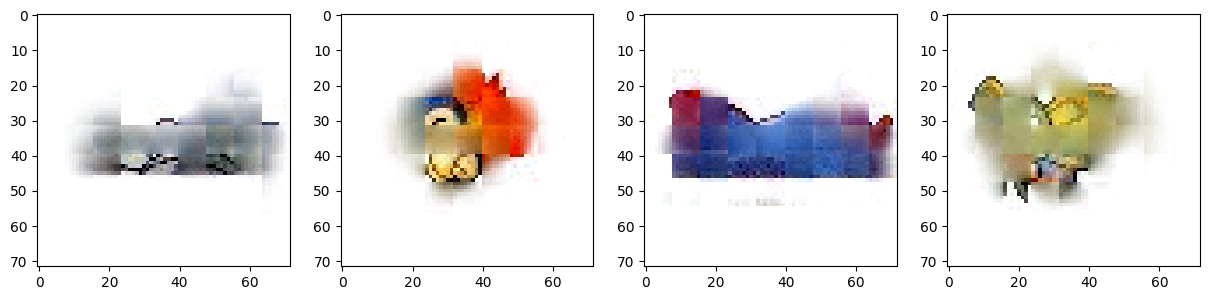

 44%|████████████████████████████████████████████████████▊                                                                   | 110000/250000 [30:15<38:18, 60.92it/s]

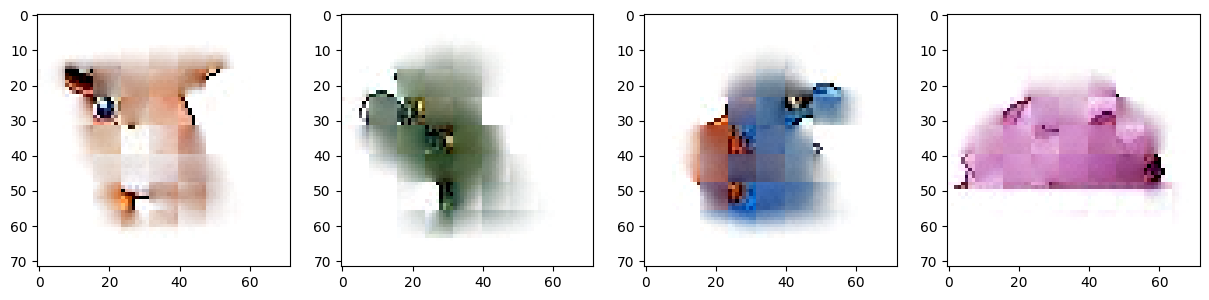

 45%|█████████████████████████████████████████████████████▊                                                                  | 112000/250000 [30:48<37:45, 60.92it/s]

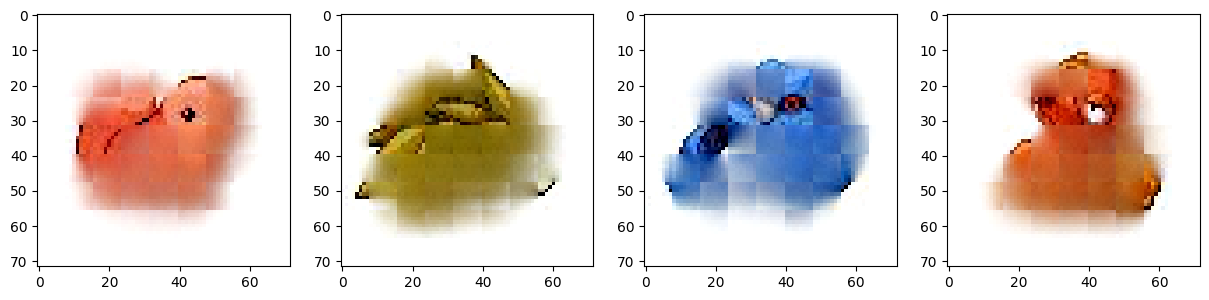

 46%|██████████████████████████████████████████████████████▋                                                                 | 114000/250000 [31:21<37:05, 61.11it/s]

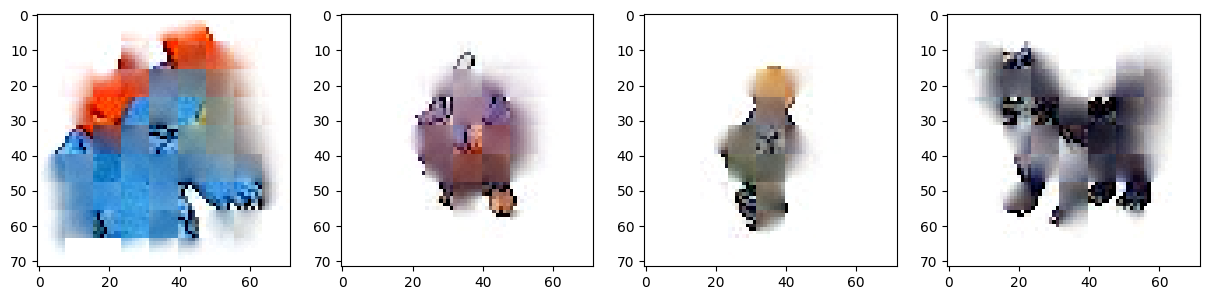

 46%|███████████████████████████████████████████████████████▋                                                                | 116000/250000 [31:54<36:42, 60.83it/s]

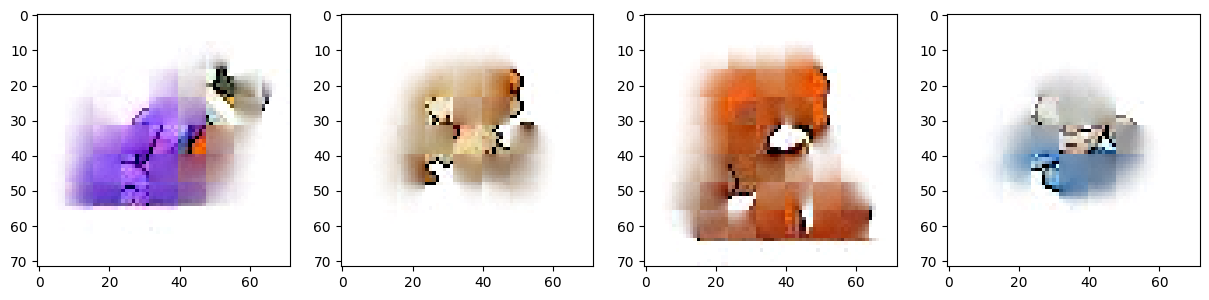

 47%|████████████████████████████████████████████████████████▋                                                               | 118000/250000 [32:27<35:55, 61.24it/s]

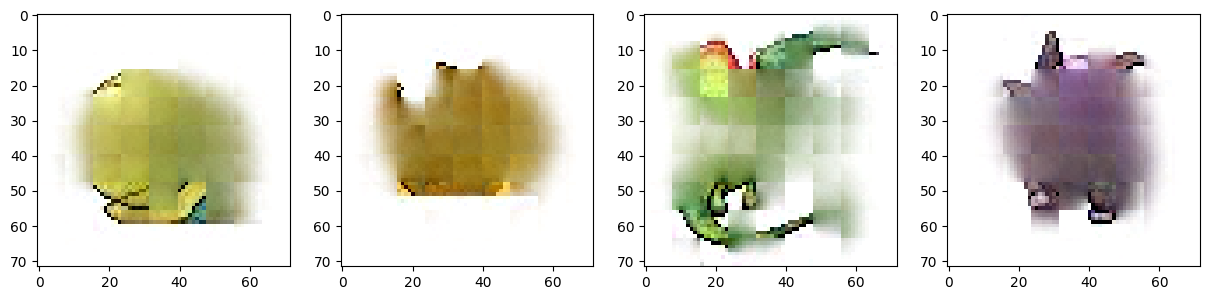

 48%|█████████████████████████████████████████████████████████▌                                                              | 120000/250000 [33:00<35:44, 60.63it/s]

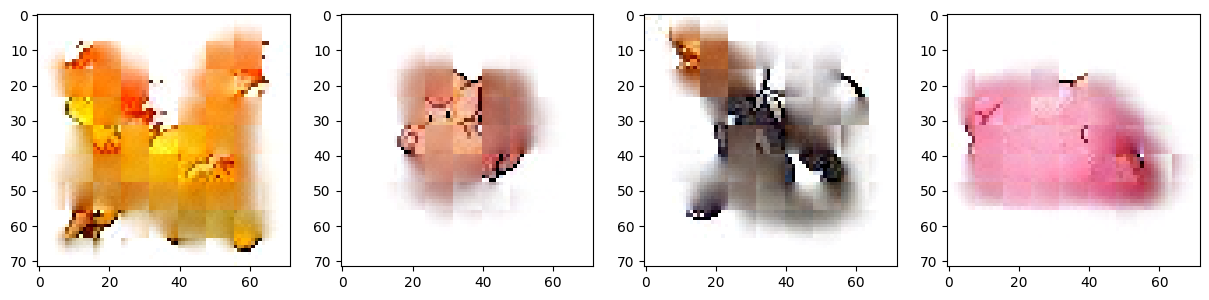

 49%|██████████████████████████████████████████████████████████▌                                                             | 122000/250000 [33:33<34:39, 61.55it/s]

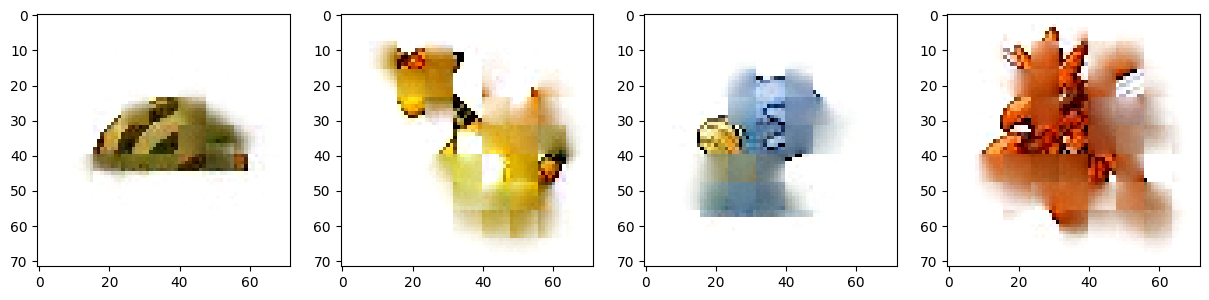

 50%|███████████████████████████████████████████████████████████▌                                                            | 124000/250000 [34:06<34:35, 60.71it/s]

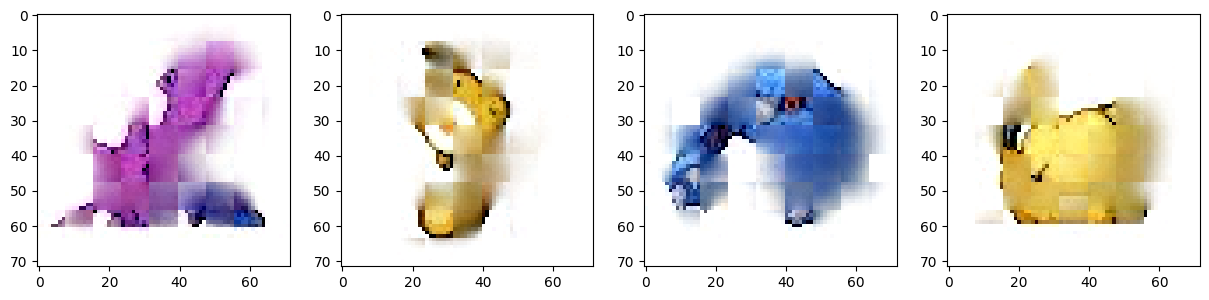

 50%|████████████████████████████████████████████████████████████▍                                                           | 126000/250000 [34:39<35:04, 58.92it/s]

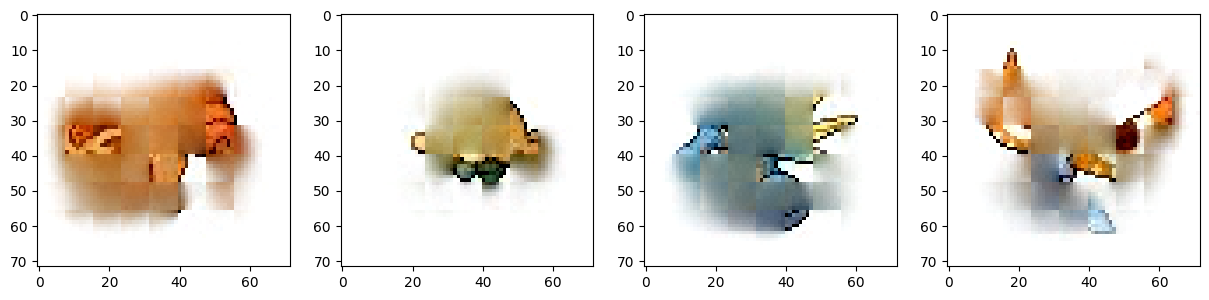

 51%|█████████████████████████████████████████████████████████████▍                                                          | 128000/250000 [35:12<34:20, 59.22it/s]

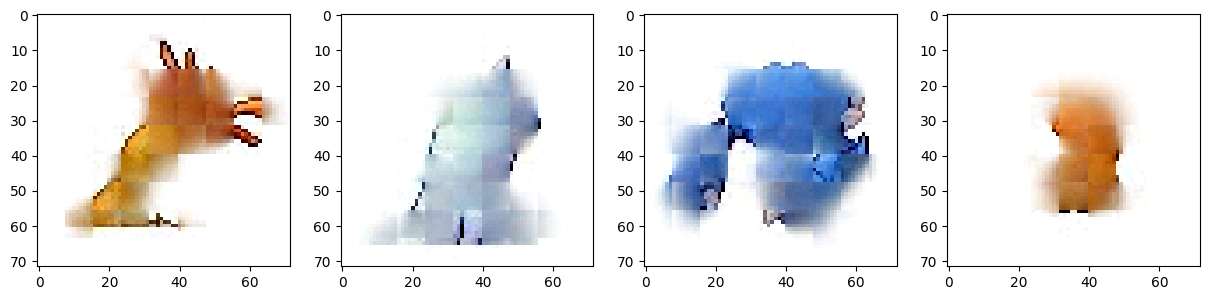

 52%|██████████████████████████████████████████████████████████████▍                                                         | 130000/250000 [35:45<32:38, 61.26it/s]

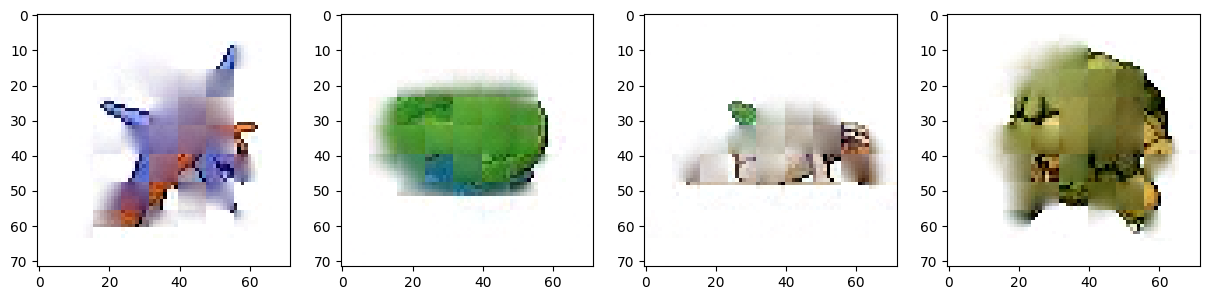

 53%|███████████████████████████████████████████████████████████████▎                                                        | 132000/250000 [36:19<31:55, 61.60it/s]

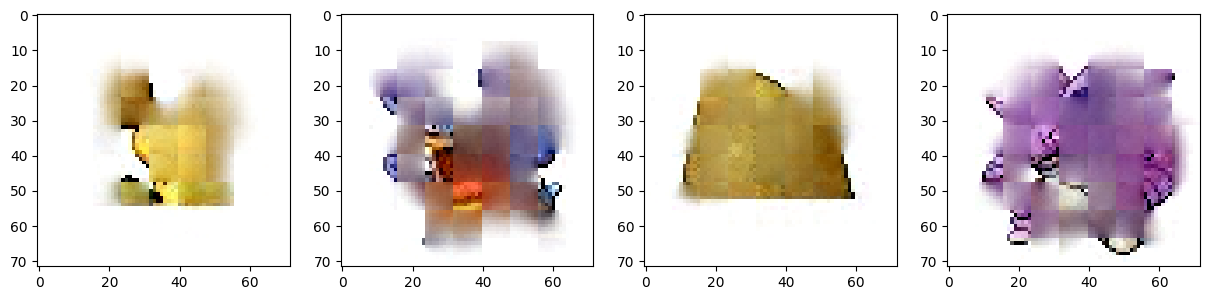

 54%|████████████████████████████████████████████████████████████████▎                                                       | 134000/250000 [36:52<31:23, 61.58it/s]

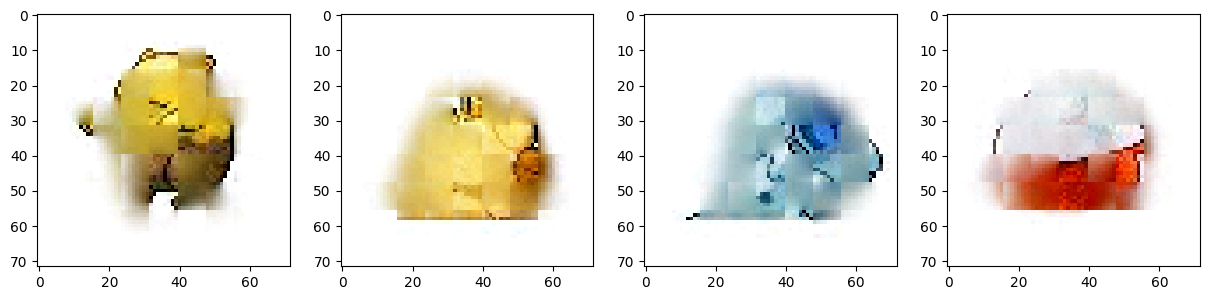

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 136000/250000 [37:25<31:08, 61.01it/s]

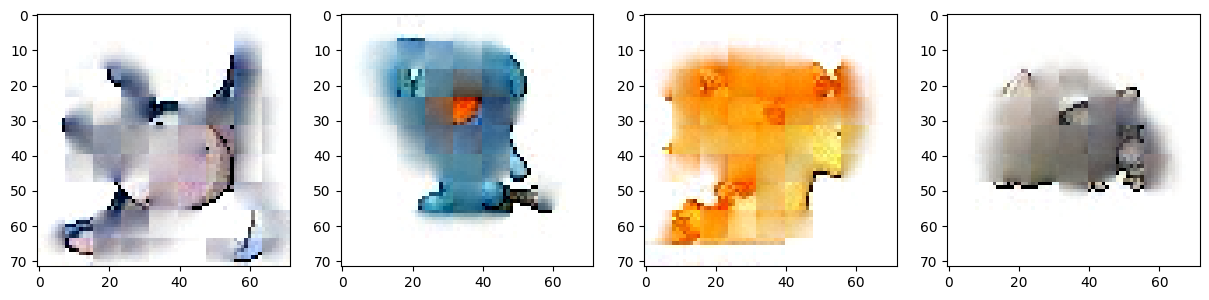

 55%|██████████████████████████████████████████████████████████████████▏                                                     | 138000/250000 [37:58<30:40, 60.87it/s]

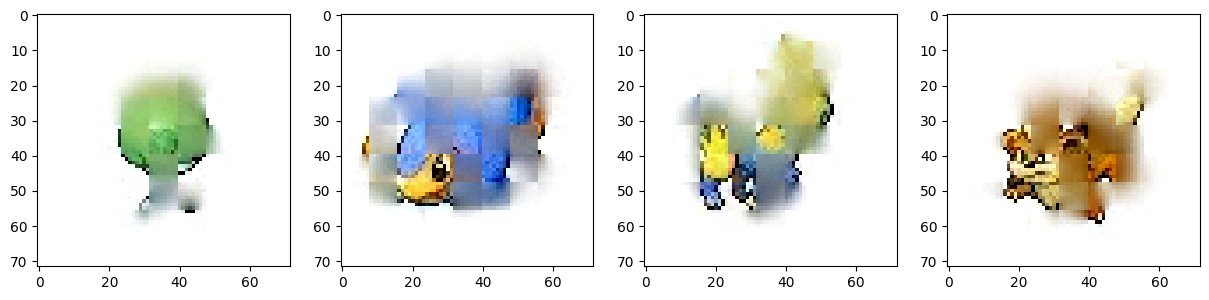

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 140000/250000 [38:31<29:53, 61.34it/s]

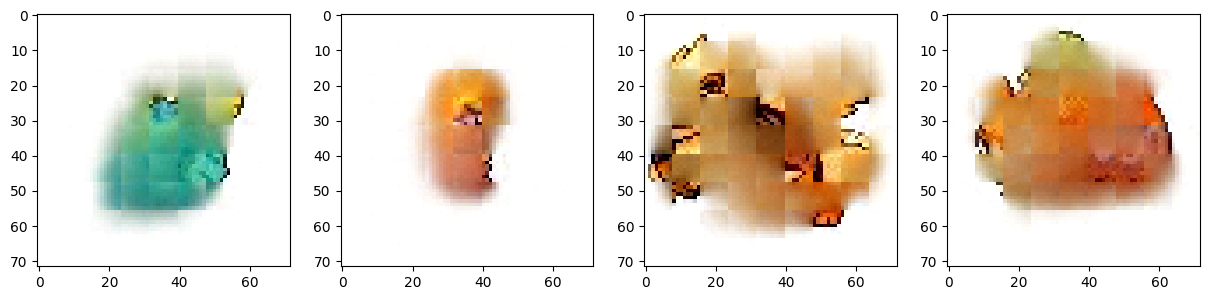

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 142000/250000 [39:04<29:52, 60.26it/s]

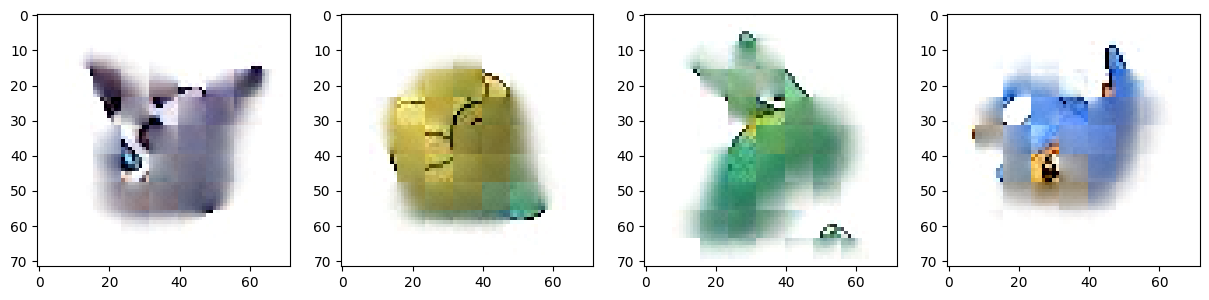

 58%|█████████████████████████████████████████████████████████████████████                                                   | 144000/250000 [39:37<29:14, 60.40it/s]

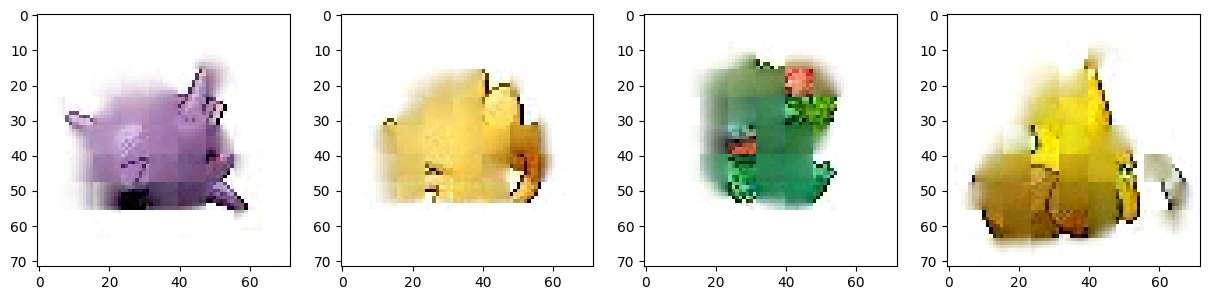

 58%|██████████████████████████████████████████████████████████████████████                                                  | 146000/250000 [40:10<29:13, 59.32it/s]

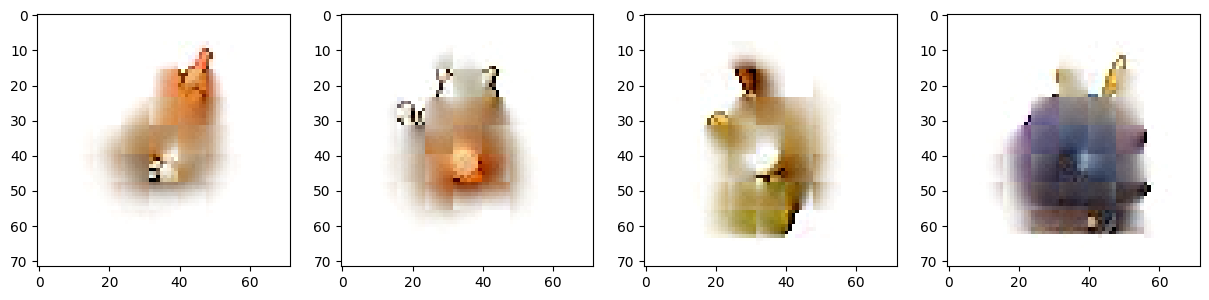

 59%|███████████████████████████████████████████████████████████████████████                                                 | 148000/250000 [40:44<28:25, 59.81it/s]

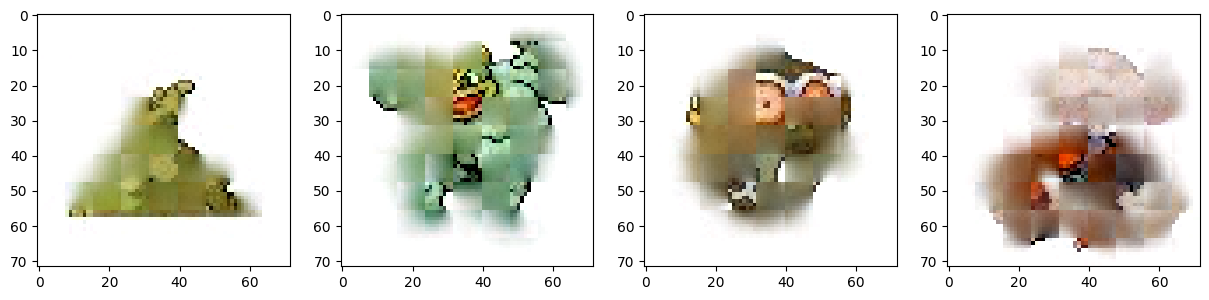

 60%|████████████████████████████████████████████████████████████████████████                                                | 150000/250000 [41:17<27:19, 61.01it/s]

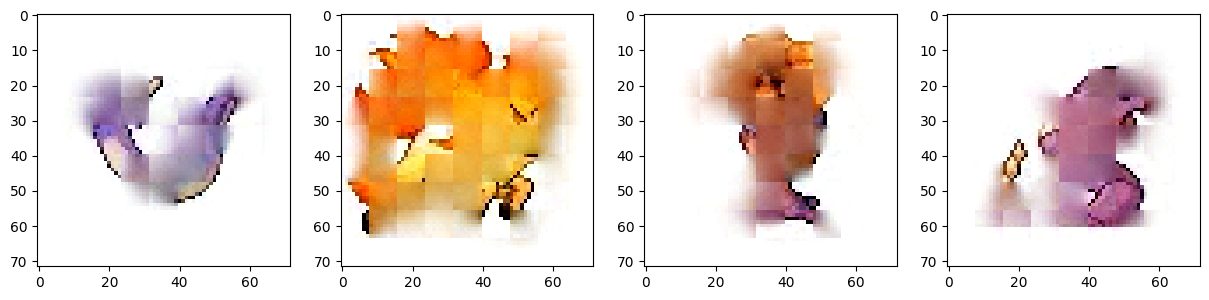

 61%|████████████████████████████████████████████████████████████████████████▉                                               | 152000/250000 [41:50<27:13, 59.99it/s]

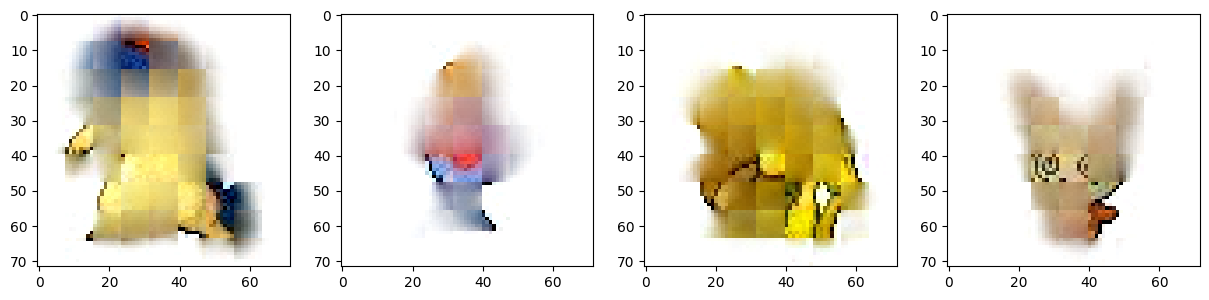

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 154000/250000 [42:23<26:30, 60.35it/s]

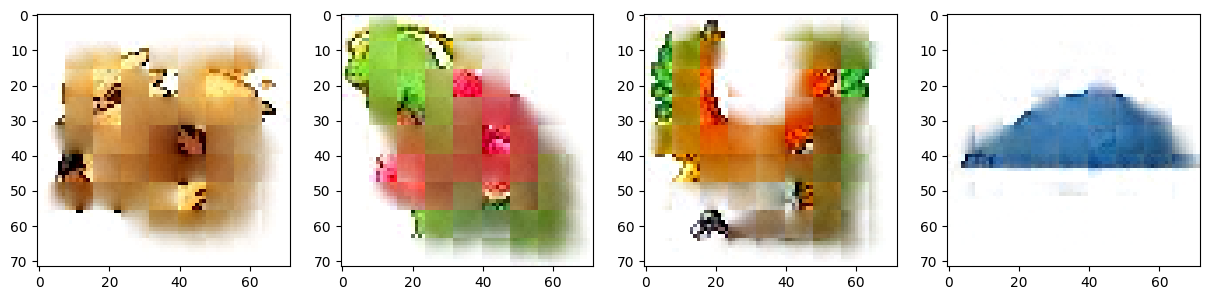

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 156000/250000 [42:56<25:54, 60.47it/s]

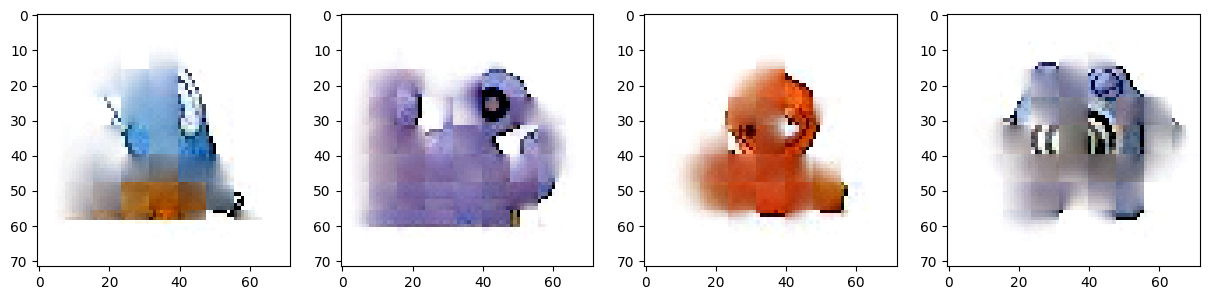

 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 158000/250000 [43:29<25:48, 59.41it/s]

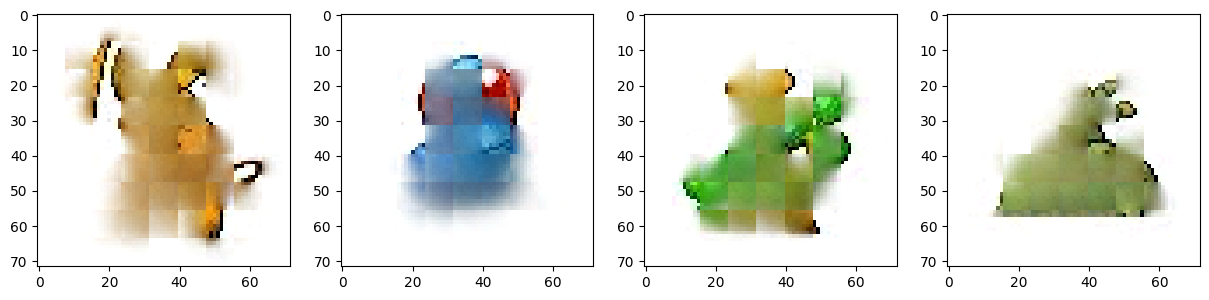

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 160000/250000 [44:02<24:33, 61.06it/s]

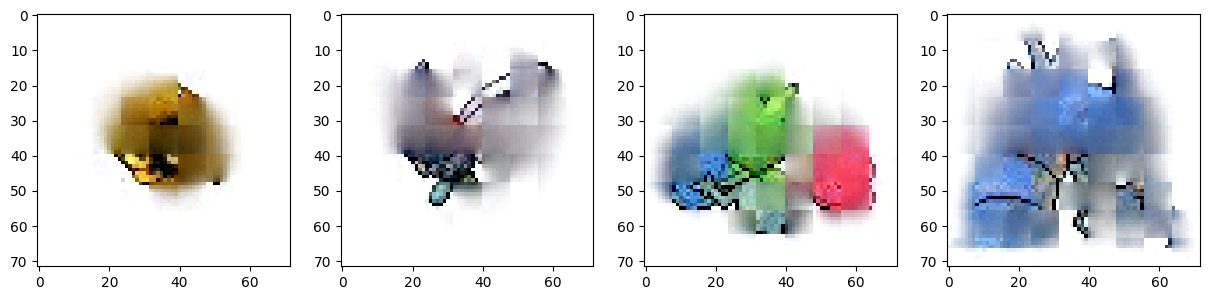

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 162000/250000 [44:36<24:02, 61.01it/s]

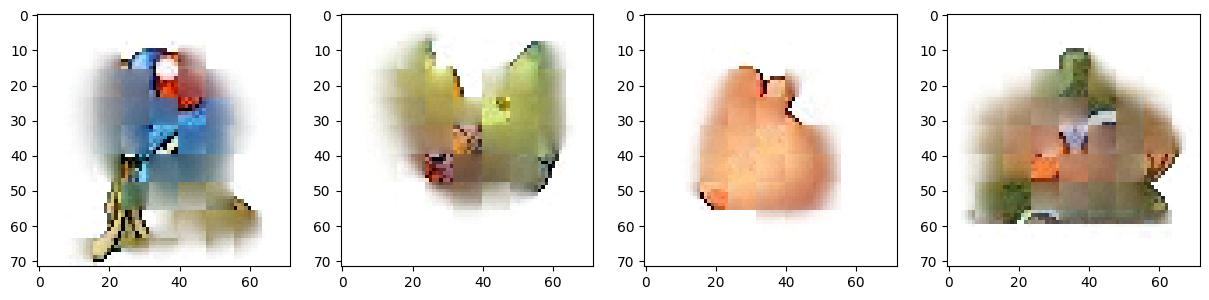

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 164000/250000 [45:09<23:44, 60.36it/s]

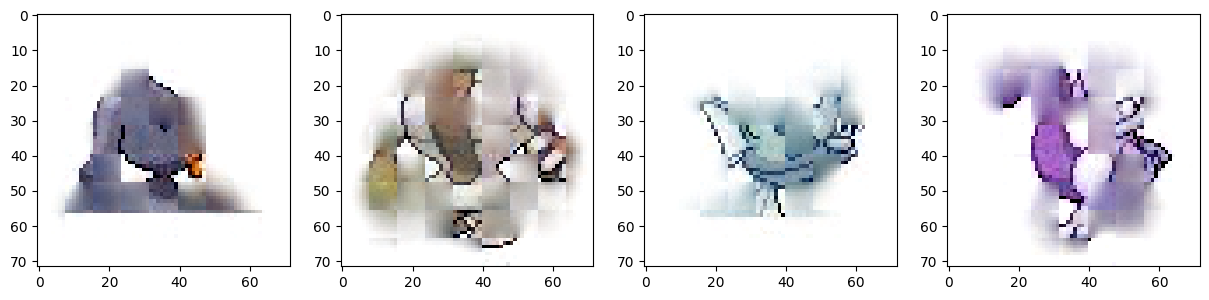

 66%|███████████████████████████████████████████████████████████████████████████████▋                                        | 166000/250000 [45:42<23:11, 60.37it/s]

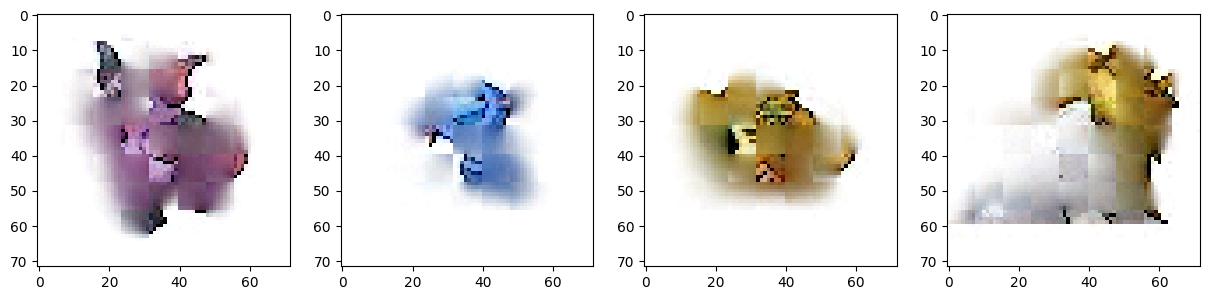

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 168000/250000 [46:15<21:50, 62.58it/s]

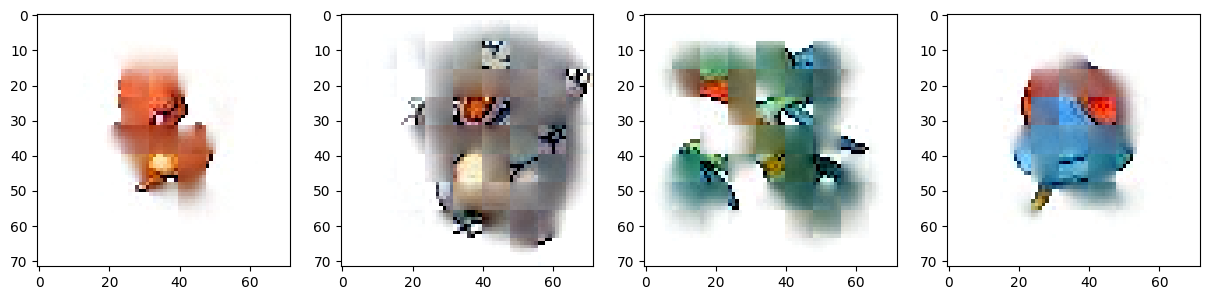

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 170000/250000 [46:48<21:56, 60.78it/s]

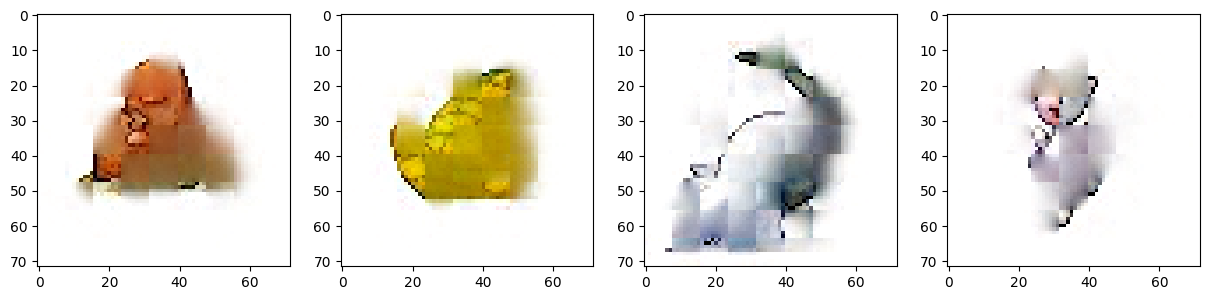

 69%|██████████████████████████████████████████████████████████████████████████████████▌                                     | 172000/250000 [47:21<21:31, 60.40it/s]

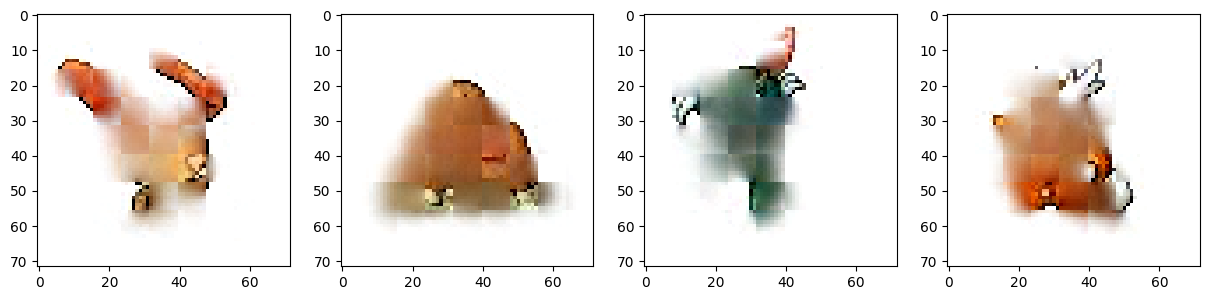

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 174000/250000 [47:54<21:02, 60.18it/s]

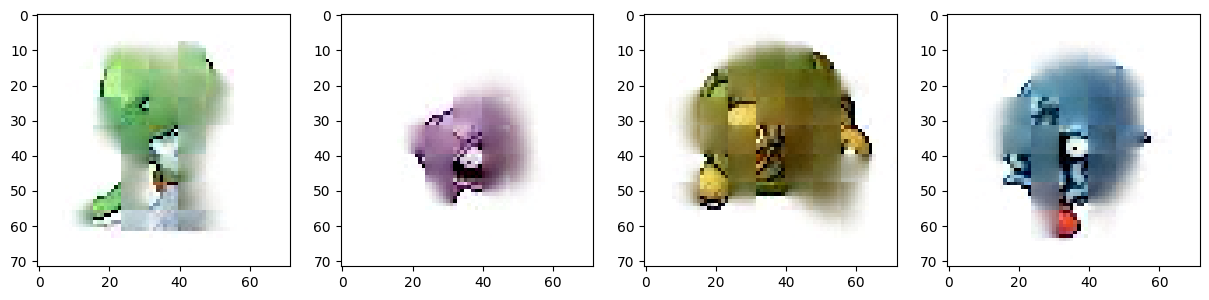

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 176000/250000 [48:27<20:30, 60.14it/s]

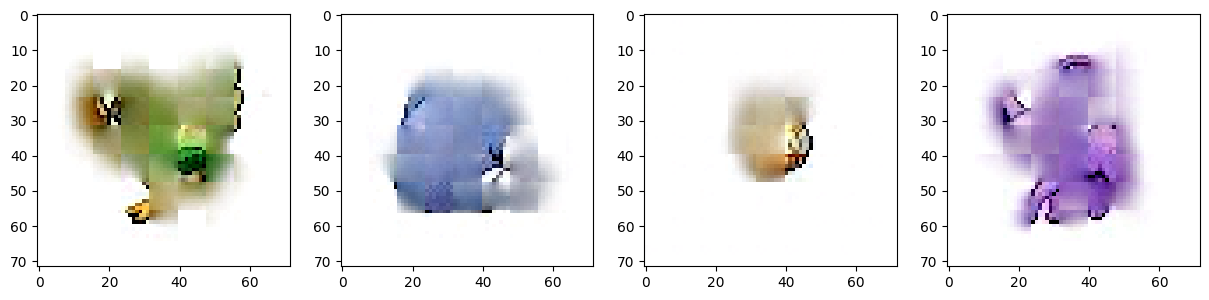

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 178000/250000 [49:00<19:38, 61.08it/s]

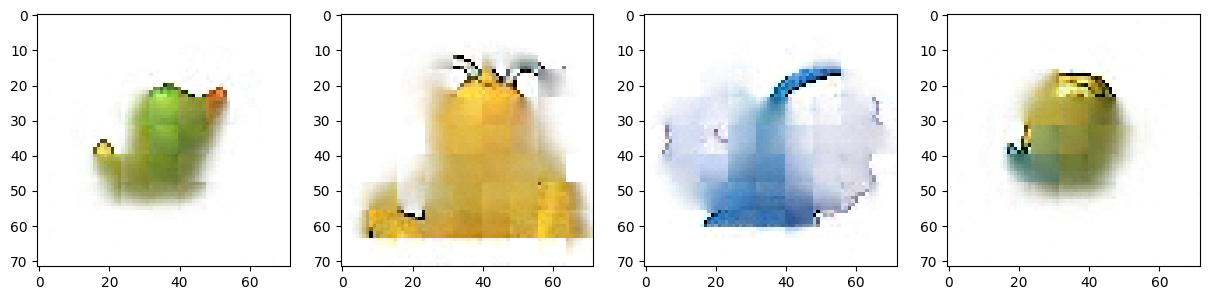

 72%|██████████████████████████████████████████████████████████████████████████████████████▍                                 | 180000/250000 [49:33<19:00, 61.37it/s]

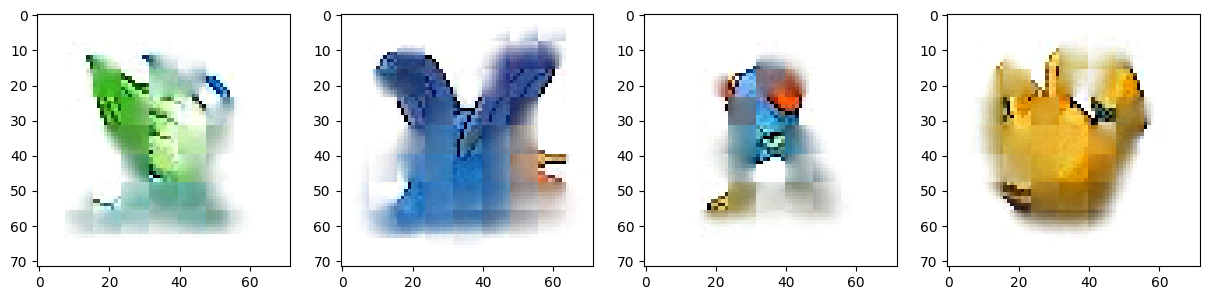

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 182000/250000 [50:06<18:49, 60.23it/s]

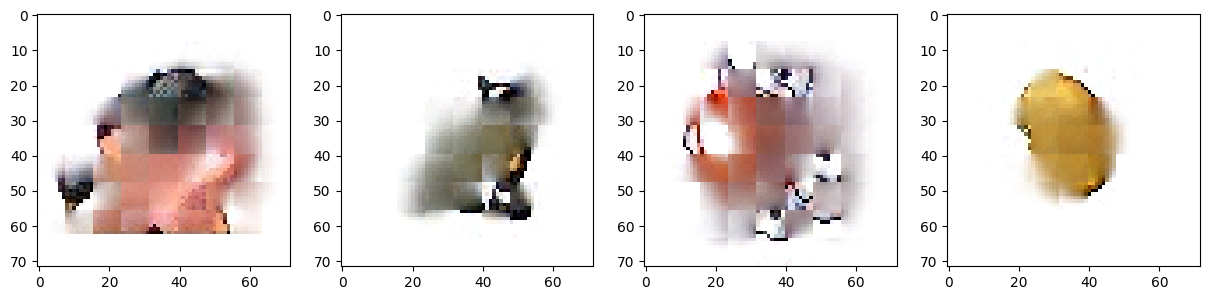

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 184000/250000 [50:39<17:39, 62.28it/s]

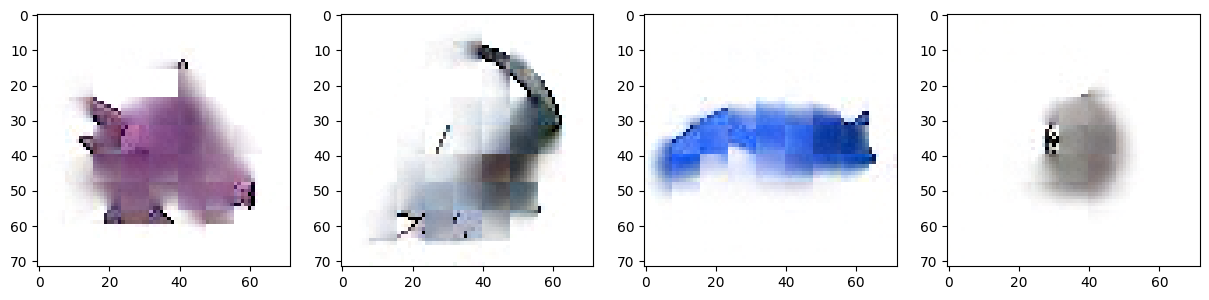

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 186000/250000 [51:13<17:45, 60.07it/s]

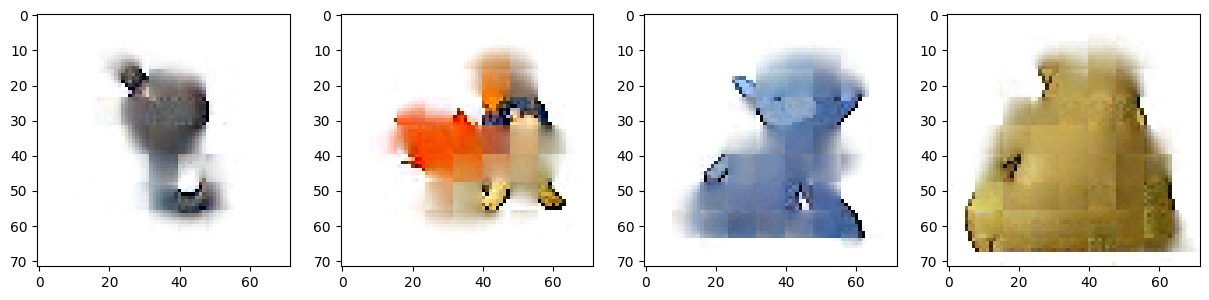

 75%|██████████████████████████████████████████████████████████████████████████████████████████▏                             | 188000/250000 [51:46<16:36, 62.19it/s]

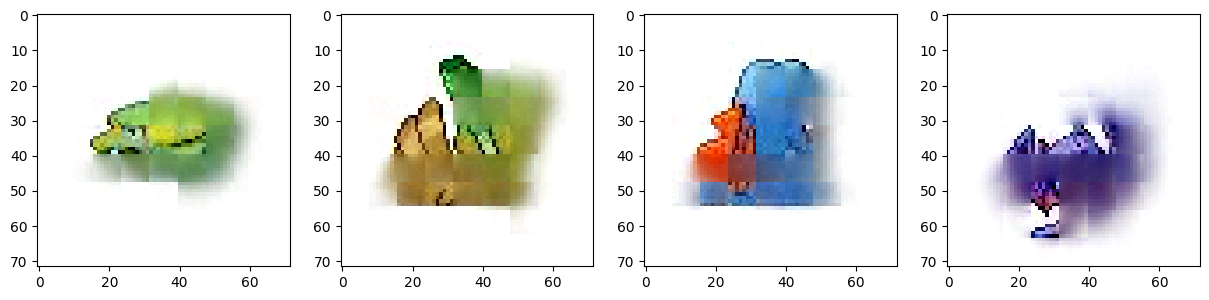

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 190000/250000 [52:19<16:19, 61.27it/s]

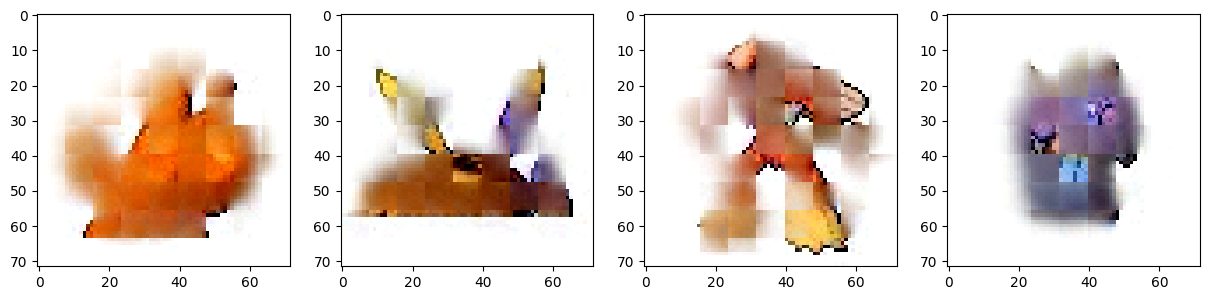

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 192000/250000 [52:52<15:44, 61.43it/s]

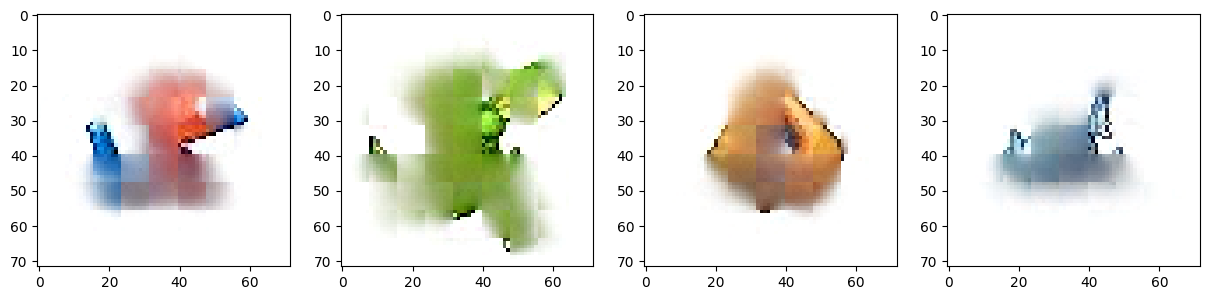

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 194000/250000 [53:25<15:26, 60.44it/s]

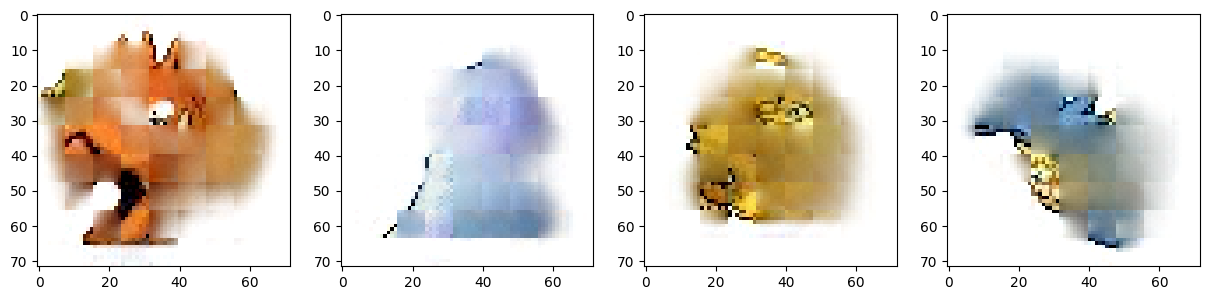

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 196000/250000 [53:58<14:50, 60.66it/s]

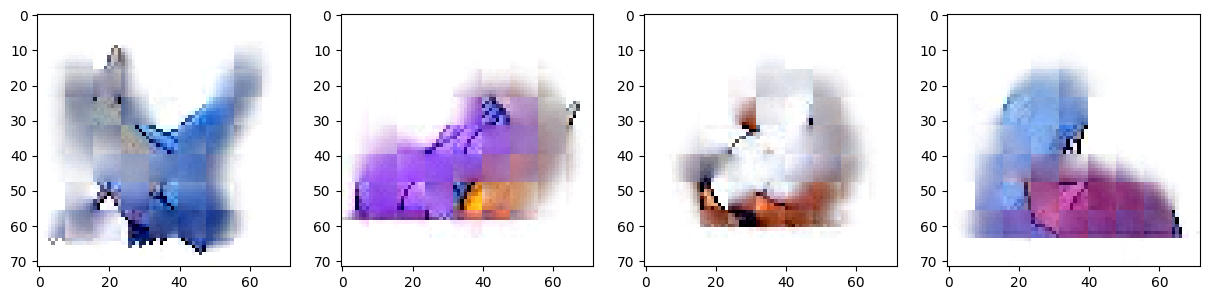

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 198000/250000 [54:31<14:14, 60.86it/s]

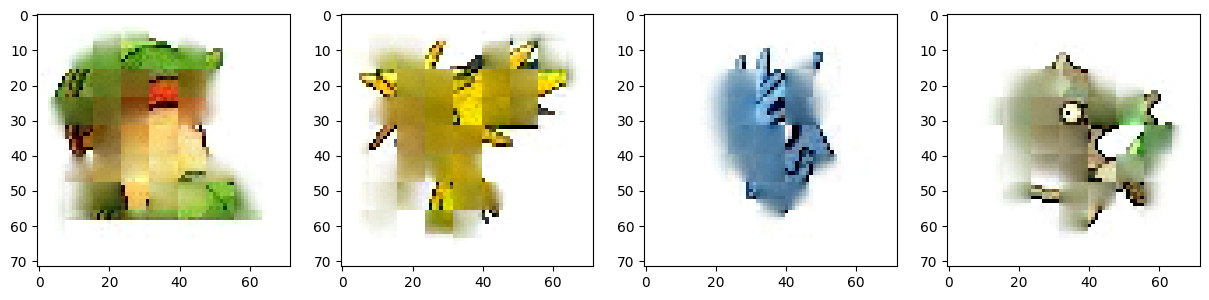

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 200000/250000 [55:04<13:38, 61.11it/s]

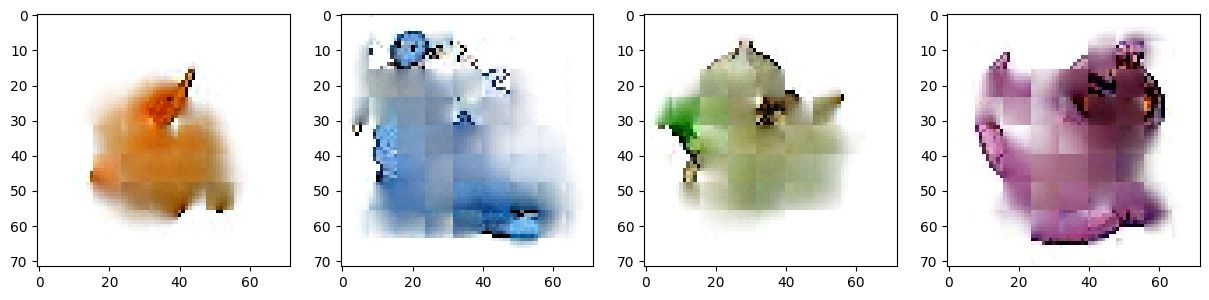

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 202000/250000 [55:38<13:23, 59.76it/s]

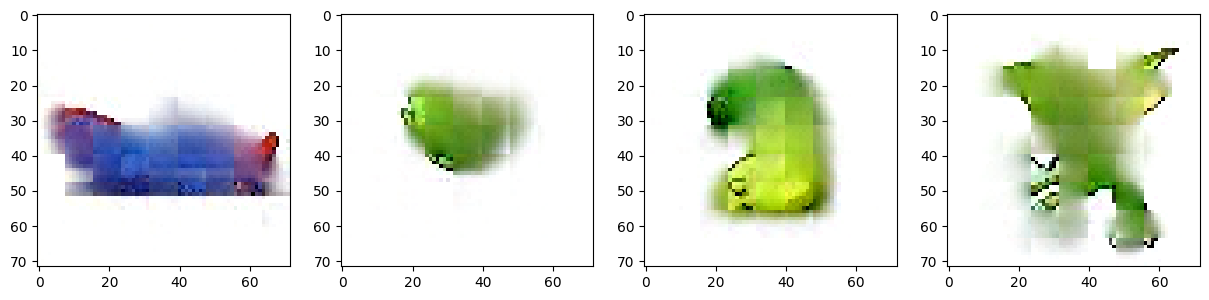

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 204000/250000 [56:11<12:54, 59.39it/s]

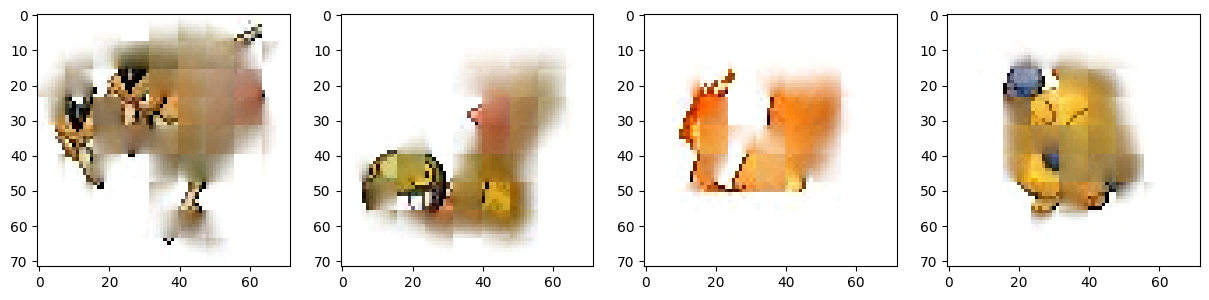

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 206000/250000 [56:44<11:45, 62.36it/s]

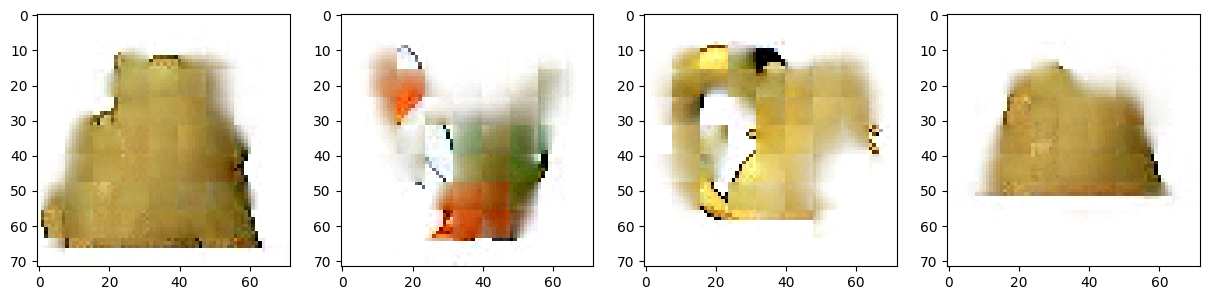

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 208000/250000 [57:17<11:22, 61.52it/s]

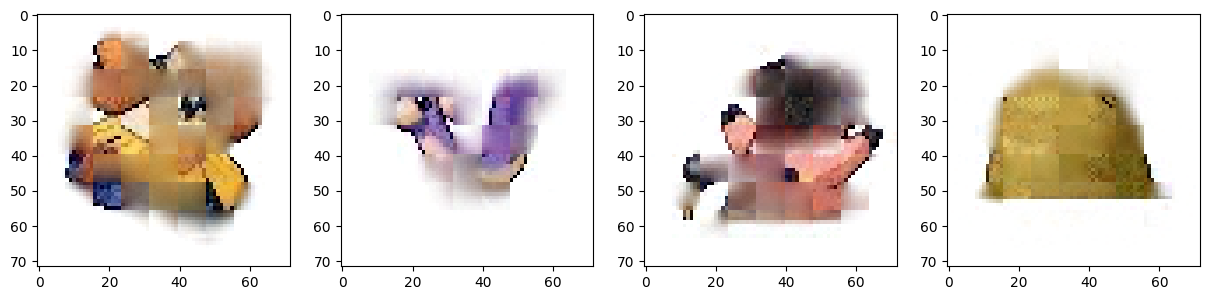

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 210000/250000 [57:50<10:57, 60.82it/s]

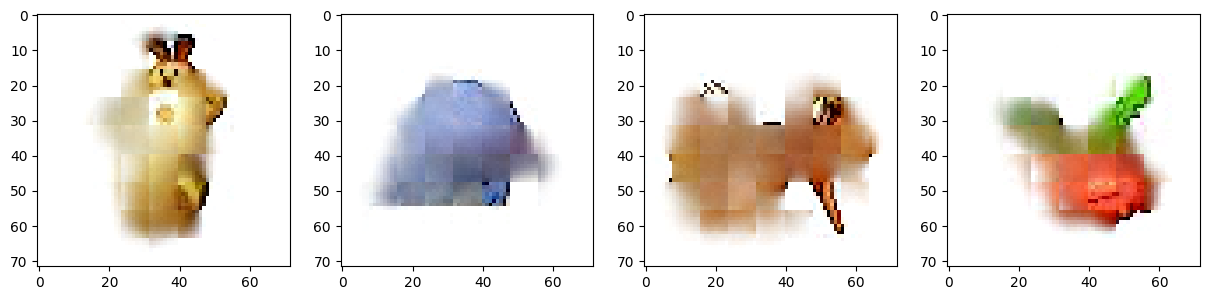

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 212000/250000 [58:23<10:42, 59.17it/s]

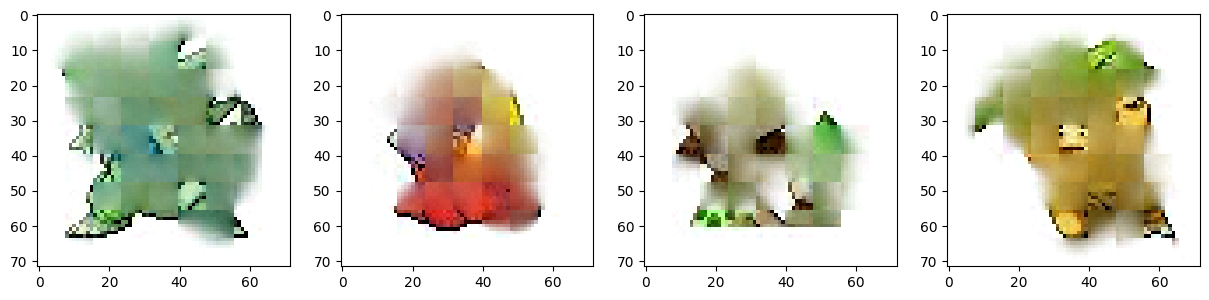

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 214000/250000 [58:56<10:06, 59.39it/s]

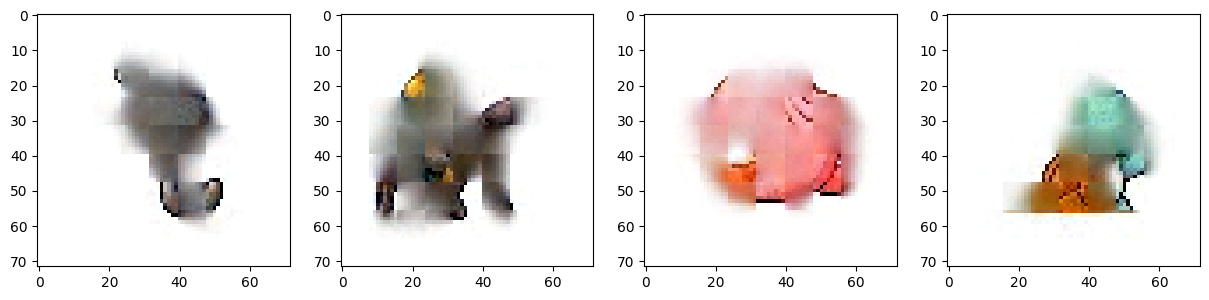

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 216000/250000 [59:29<09:33, 59.27it/s]

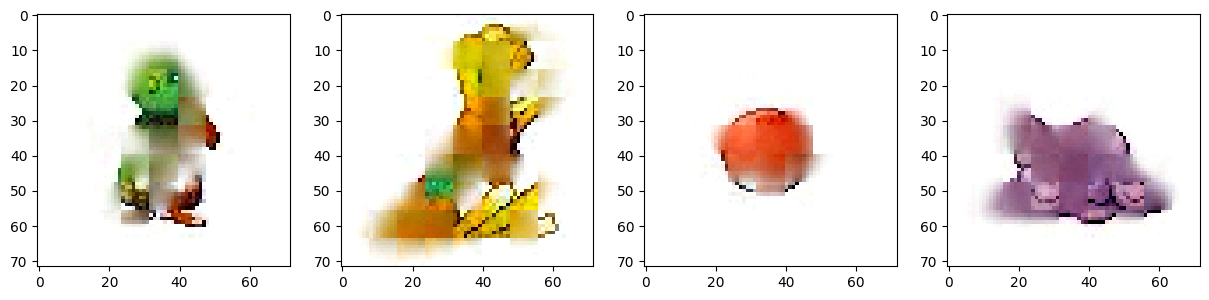

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 218000/250000 [1:00:02<08:54, 59.88it/s]

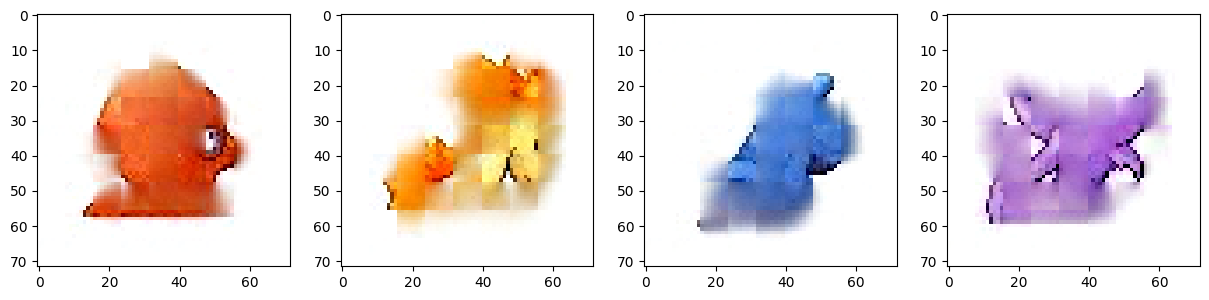

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 220000/250000 [1:00:36<08:18, 60.24it/s]

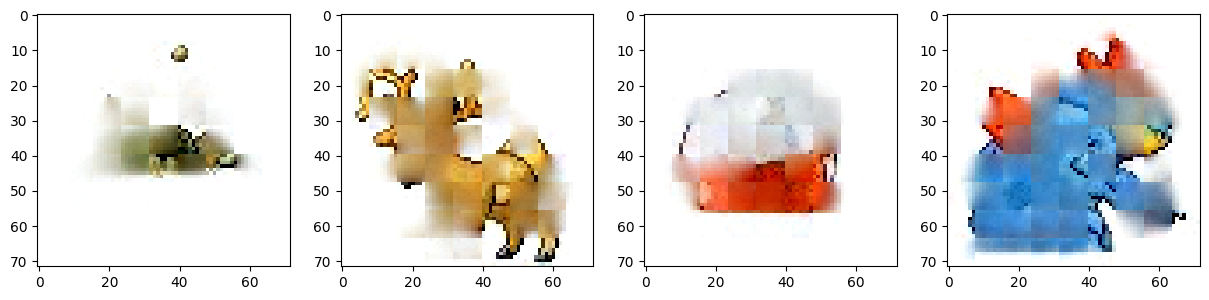

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 222000/250000 [1:01:09<07:47, 59.93it/s]

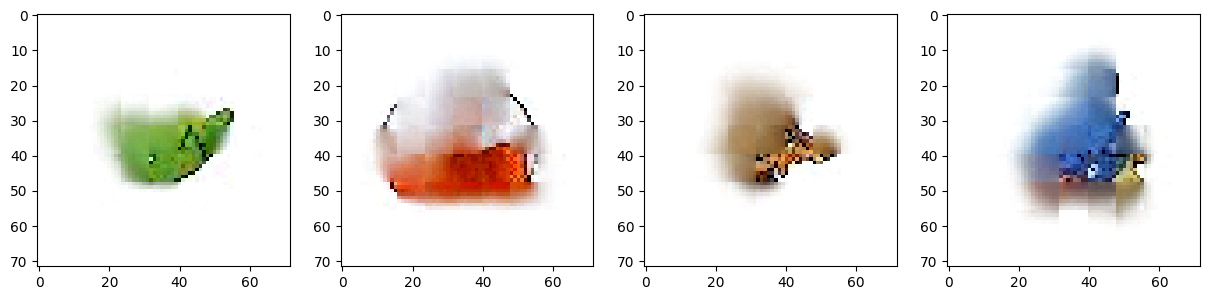

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 224000/250000 [1:01:42<07:10, 60.39it/s]

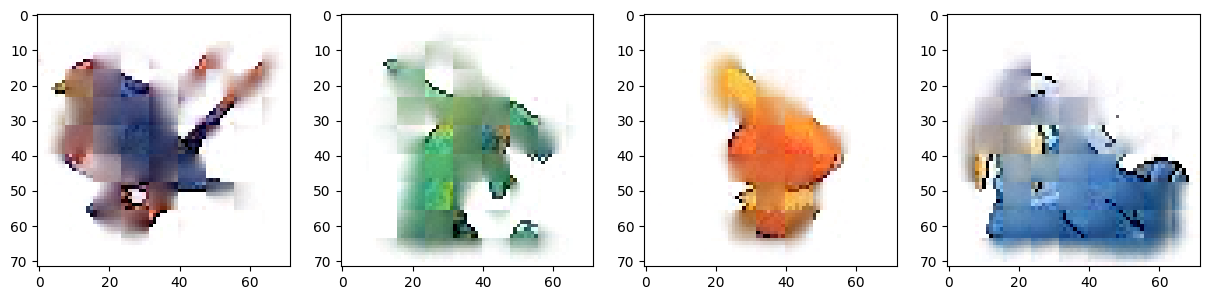

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 226000/250000 [1:02:15<06:36, 60.56it/s]

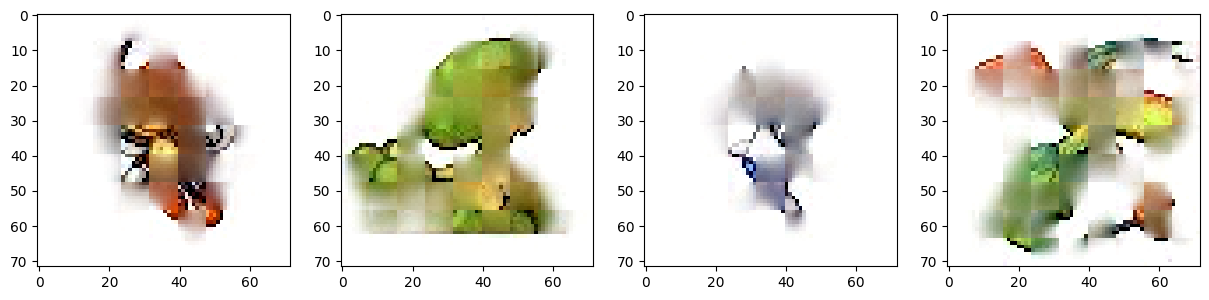

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 228000/250000 [1:02:48<06:08, 59.67it/s]

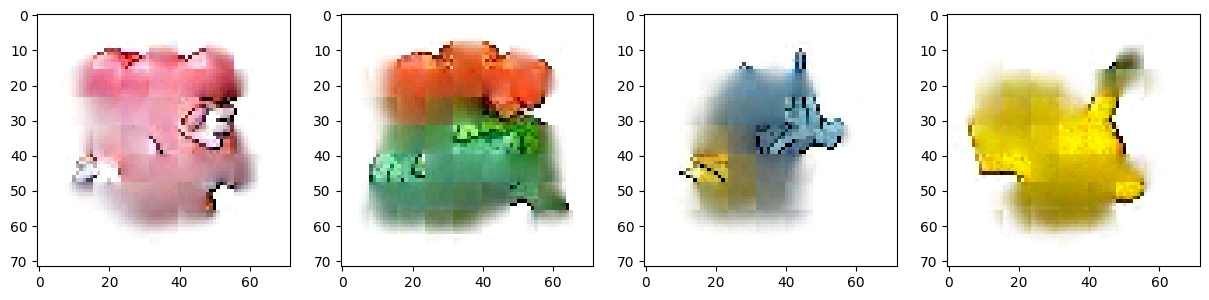

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 230000/250000 [1:03:21<05:27, 61.13it/s]

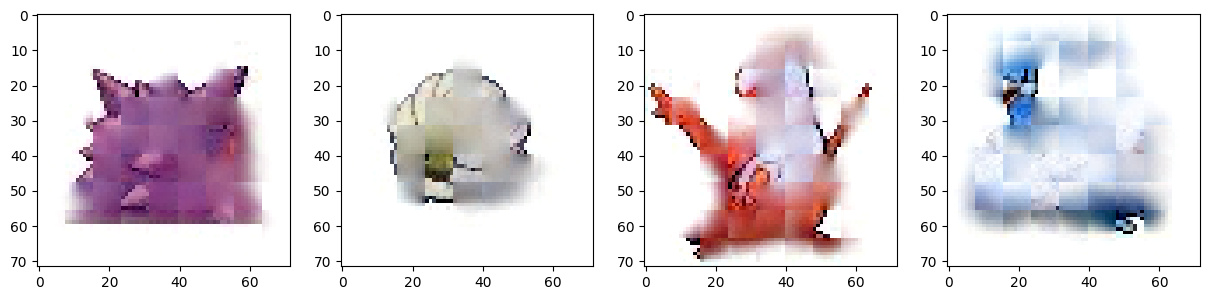

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 232000/250000 [1:03:55<04:57, 60.57it/s]

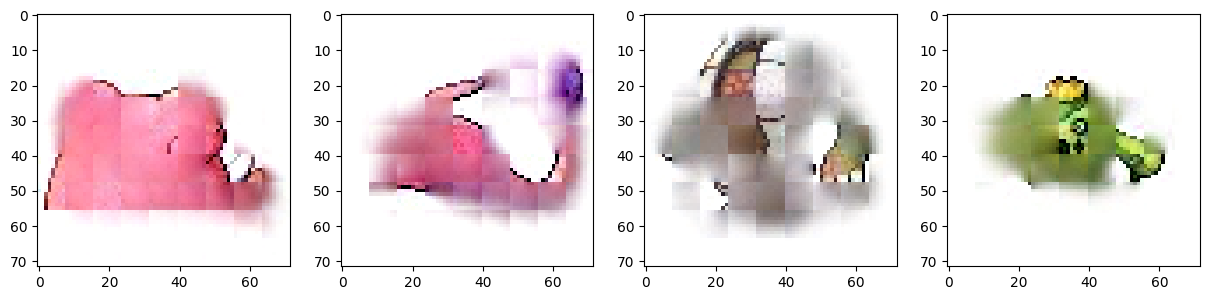

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 234000/250000 [1:04:28<04:22, 61.01it/s]

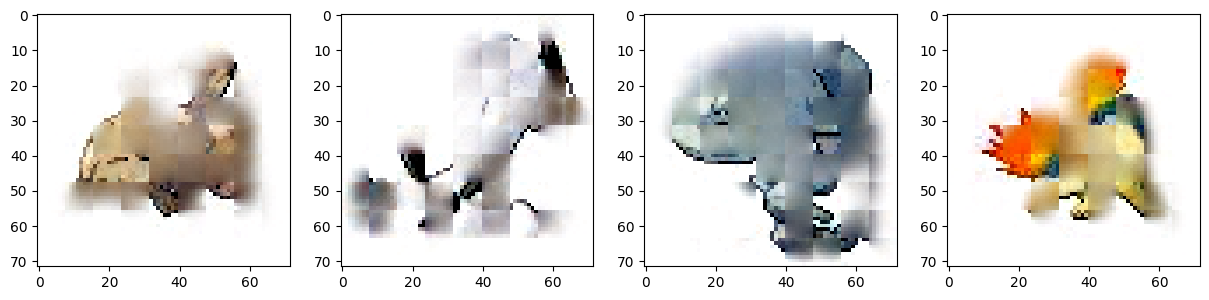

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 236000/250000 [1:05:01<03:49, 60.99it/s]

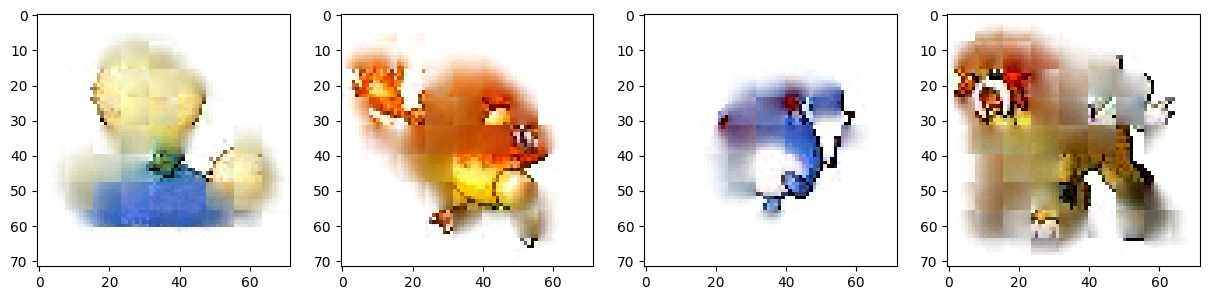

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 238000/250000 [1:05:34<03:15, 61.47it/s]

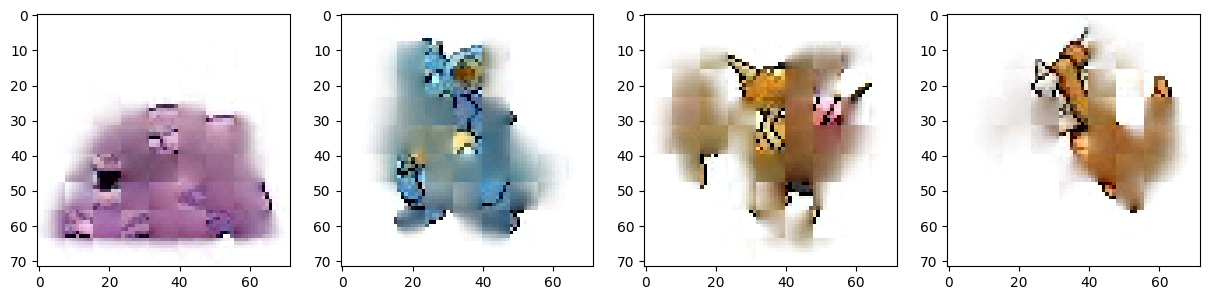

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 240000/250000 [1:06:07<02:42, 61.36it/s]

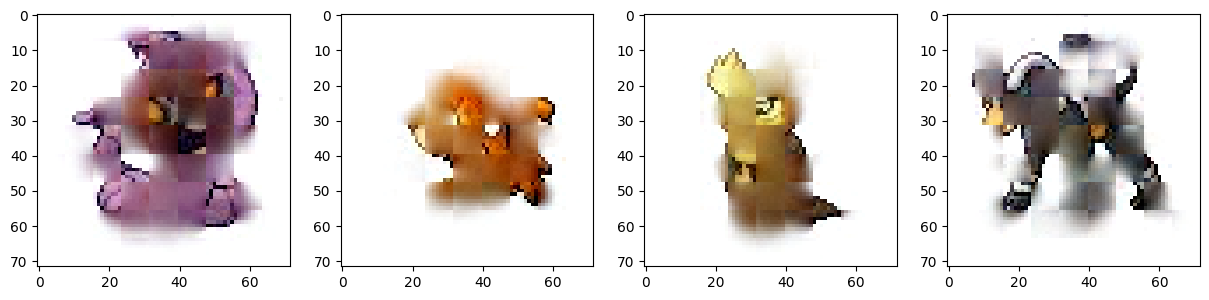

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 242000/250000 [1:06:40<02:11, 60.90it/s]

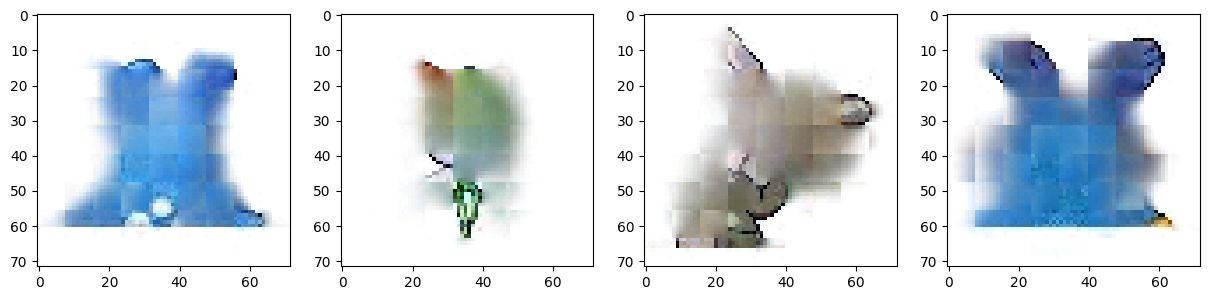

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 244000/250000 [1:07:13<01:39, 60.43it/s]

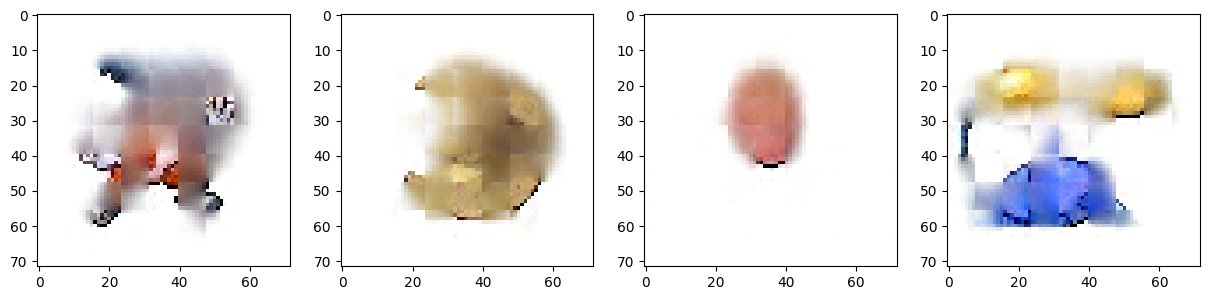

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 246000/250000 [1:07:46<01:06, 60.01it/s]

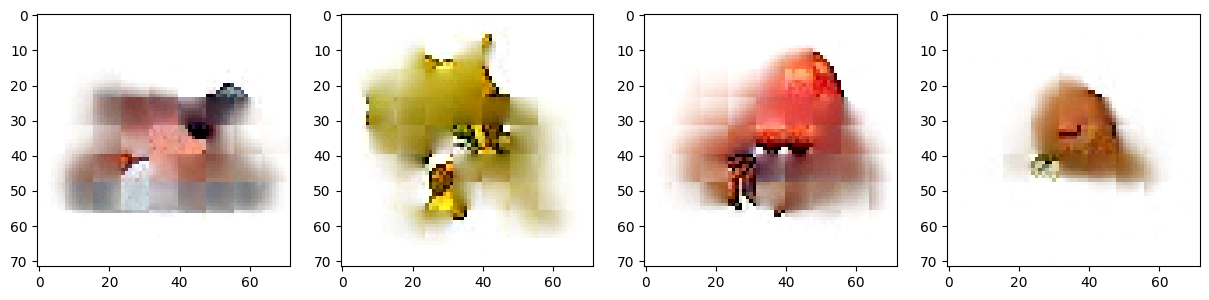

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 248000/250000 [1:08:19<00:32, 60.98it/s]

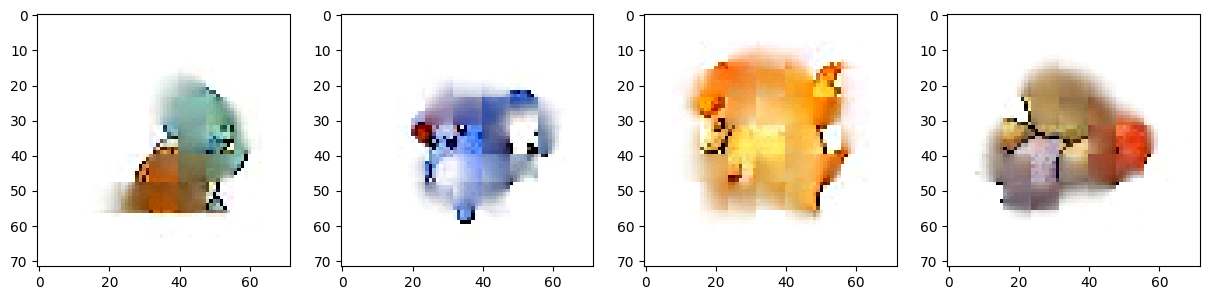

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [1:08:52<00:00, 60.50it/s]


In [5]:
model = MyMAE(72, 8, 96).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
mse_loss = nn.MSELoss()

def train():

    for i in tqdm(range(250000), miniters=10):
        bs = 32
        source = torch.randint(0, 5, (bs,))
        batch = torch.randperm(385)[:bs]
        x0 = pimages[source, batch]
        x0 = torch.stack([pos_transform(x) for x in x0], dim=0)

        optimizer.zero_grad()

        reconstruction = model(x0)
        loss = mse_loss(reconstruction, x0) + 1.0 * ssim_loss(reconstruction, x0).mean()

        loss.backward()
        optimizer.step()

        if i % 2000 == 0:
            fig, axes = plt.subplots(1, 4, figsize=(15, 15))
            plot_image(reconstruction[0], axes[0])
            plot_image(reconstruction[1], axes[1])
            plot_image(reconstruction[2], axes[2])
            plot_image(reconstruction[3], axes[3])
            plt.show()

model.train()
train()
